In [ ]:
# Import required libraries for data processing, visualization, feature extraction, and ML
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import tldextract
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
# Load dataset
df = pd.read_csv("CEAS_08.csv")
df.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


In [3]:
# Remove rows missing subject or body
df = df.dropna(subset=['subject', 'body'])

# Combine subject + body into a single text field
df["text"] = df["subject"].astype(str) + " " + df["body"].astype(str)

# Keep only relevant columns
df = df[["sender", "text", "label"]]

df.head()

,sender,text,label
0,Young Esposito <Young@iworld.de>,"Never agree to be a loser Buck up, your troubl...",1
1,Mok <ipline's1983@icable.ph>,Befriend Jenna Jameson \nUpgrade your sex and ...,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...,1
3,Michael Parker <ivqrnai@pobox.com>,Re: svn commit: r619753 - in /spamassassin/tru...,0
4,Gretchen Suggs <externalsep1@loanofficertool.com>,SpecialPricesPharmMoreinfo \nWelcomeFastShippi...,1


In [ ]:
# Save cleaned dataset
df.to_csv("modified_dataset.csv", index=False)
df.head()

,sender,text,label
0,Young Esposito <Young@iworld.de>,"Never agree to be a loser Buck up, your troubl...",1
1,Mok <ipline's1983@icable.ph>,Befriend Jenna Jameson \nUpgrade your sex and ...,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...,1
3,Michael Parker <ivqrnai@pobox.com>,Re: svn commit: r619753 - in /spamassassin/tru...,0
4,Gretchen Suggs <externalsep1@loanofficertool.com>,SpecialPricesPharmMoreinfo \nWelcomeFastShippi...,1


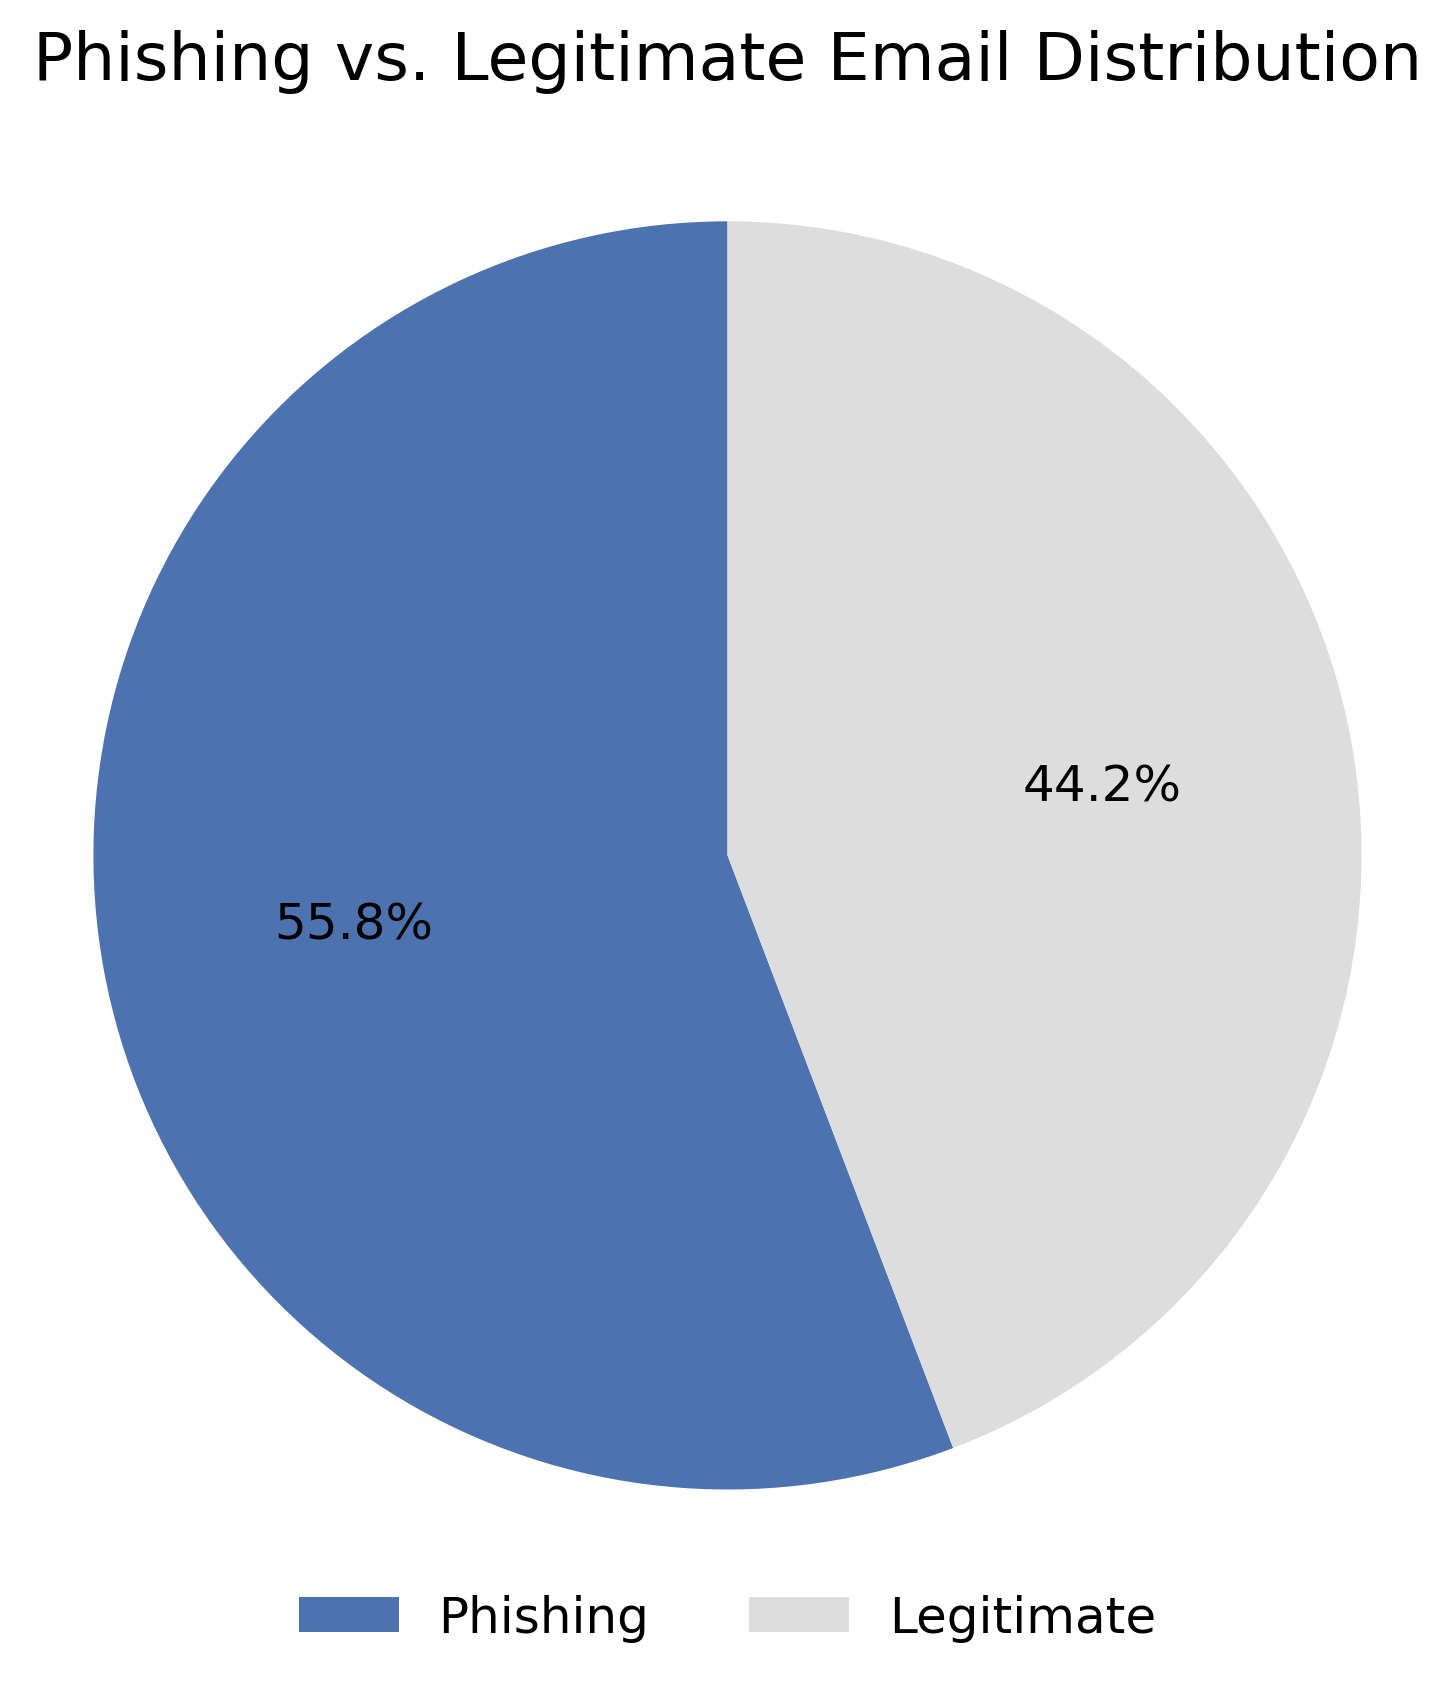

In [126]:
# Dataset Label Distribution

# Count phishing and legitimate emails
label_counts = df["label"].value_counts()
labels = ["Phishing", "Legitimate"]
sizes = [label_counts[1], label_counts[0]]

# Set colors
colors = ["#4C72B0", "#DDDDDD"]

# Create a high-resolution figure
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

# Plot the label distribution as a pie chart
wedges, texts, autotexts = ax.pie(
    sizes,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    textprops={"fontsize": 12}
)

# Make chart circular
ax.axis("equal")

ax.set_title("Phishing vs. Legitimate Email Distribution", fontsize=16, pad=20)

ax.legend(
    wedges,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    fontsize=12,
    frameon=False
)

## fig.savefig("label_distribution_pie.png", dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
# Train-Test Split

# Extract features and labels
email_text = df["text"]
sender_address = df["sender"]
labels = df["label"]

# Split data into training and testing sets
X_train_text_raw, X_test_text_raw, X_train_sender, X_test_sender, y_labels_train, y_labels_test = train_test_split(
    email_text, sender_address, labels, test_size=0.2, stratify=labels, random_state=42
)

In [ ]:
# Regex pattern to extract URLs
URL_REGEX = r'(https?://[^\s]+)'

def extract_urls(text):
    if isinstance(text, float) and np.isnan(text):
        return []
    if text is None:
        return []
    return re.findall(URL_REGEX, str(text))

def get_domain(url):
    try:
        parsed = urlparse(url)
        host = parsed.netloc.lower()
        if host.startswith("www."):
            host = host[4:]
        return host
    except:
        return ""

In [ ]:
# Suspicious TLDs & hex pattern used as phishing indicators
SUSPICIOUS_TLDS = {".ru", ".xyz", ".top", ".tk", ".icu", ".click"}
HEX_PATTERN = re.compile(r'[0-9a-fA-F]{6,}') 

def url_features_from_text(text):
    urls = extract_urls(text)
    num_urls = len(urls)

    if num_urls == 0:
        return {
            "num_urls": 0,
            "max_url_length": 0,
            "has_ip_in_url": 0,
            "has_suspicious_tld": 0,
            "many_subdomains": 0,
            "has_at_symbol": 0,
            "has_dash_in_domain": 0,
            "has_hex_string": 0
        }

    max_len = 0
    has_ip = 0
    has_suspicious_tld = 0
    many_sub = 0
    has_at_symbol = 0
    has_dash = 0
    has_hex = 0

    for u in urls:
        u_str = str(u)
        max_len = max(max_len, len(u_str))

        if "@" in u_str:
            has_at_symbol = 1

        if HEX_PATTERN.search(u_str):
            has_hex = 1

        dom = get_domain(u_str)

        # Detect URLs containing an IP address
        if re.match(r'^\d{1,3}(\.\d{1,3}){3}$', dom.split(":")[0]):
            has_ip = 1
            
        # Extract TLD + subdomain information
        ext = tldextract.extract(u_str)
        tld = "." + ext.suffix if ext.suffix else ""
        subdomain = ext.subdomain

        if tld in SUSPICIOUS_TLDS:
            has_suspicious_tld = 1
            
        # Excessive subdomains (common in phishing)
        if subdomain and subdomain.count(".") >= 2:
            many_sub = 1

        if "-" in ext.domain:
            has_dash = 1

    return {
        "num_urls": num_urls,
        "max_url_length": max_len,
        "has_ip_in_url": has_ip,
        "has_suspicious_tld": has_suspicious_tld,
        "many_subdomains": many_sub,
        "has_at_symbol": has_at_symbol,
        "has_dash_in_domain": has_dash,
        "has_hex_string": has_hex
    }

In [ ]:
# Build DataFrame of URL-based features for all emails
def build_url_feature_df(text_series):
    rows = [url_features_from_text(t) for t in text_series]
    return pd.DataFrame(rows, index=text_series.index)

# Generate URL features for train/test splits
X_train_url = build_url_feature_df(X_train_text_raw)
X_test_url  = build_url_feature_df(X_test_text_raw)

X_train_url.head()

,num_urls,max_url_length,has_ip_in_url,has_suspicious_tld,many_subdomains,has_at_symbol,has_dash_in_domain,has_hex_string
22472,1,45,0,0,0,0,0,0
31397,1,25,0,0,0,0,0,0
35710,0,0,0,0,0,0,0,0
22272,24,123,0,0,0,1,0,1
32227,6,140,0,0,0,1,0,1


In [ ]:
# Header / Sender Features

# List of common free-email providers used frequently in phishing
FREE_EMAIL_PROVIDERS = {
    "gmail.com", "yahoo.com", "hotmail.com", "outlook.com",
    "aol.com", "live.com", "msn.com", "protonmail.com"
}

# Extract domain from sender email address
def extract_sender_domain(sender):
    sender = str(sender)

    match = re.search(r'<([^>]*)>', sender)
    if match:
        sender = match.group(1)

    if "@" in sender:
        return sender.split("@")[1].lower().strip()
    return ""

In [ ]:
# Extract domain from sender email address
def header_features_from_sender(sender):
    domain = extract_sender_domain(sender)

    return {
        "sender_is_free_provider": 1 if domain in FREE_EMAIL_PROVIDERS else 0,
        "sender_domain_length": len(domain),
        "sender_has_numbers": 1 if re.search(r'\d', domain) else 0,
        "sender_has_dash": 1 if "-" in domain else 0
    }

In [ ]:
# Build DataFrame of header features for all emails
def build_header_feature_df(sender_series):
    rows = [header_features_from_sender(s) for s in sender_series]
    return pd.DataFrame(rows, index=sender_series.index)

# Generate sender/header features for train/test splits
X_train_header = build_header_feature_df(X_train_sender)
X_test_header  = build_header_feature_df(X_test_sender)

X_train_header.head()

,sender_is_free_provider,sender_domain_length,sender_has_numbers,sender_has_dash
22472,0,13,0,0
31397,0,25,0,0
35710,0,14,0,0
22272,0,9,0,1
32227,0,22,0,0


In [ ]:
# List of phishing-indicator keywords
URGENT_WORDS = [
    "urgent", "immediately", "action required", "verify", "update",
    "password", "bank", "account", "suspended", "limited", "alert",
    "important", "warning"
]

In [ ]:
# Extract text-based phishing features
def text_features_from_text(text):
    original = str(text)
    text = str(text).lower()
    
    # 1. Urgent words count
    urgent_count = sum(word in text for word in URGENT_WORDS)
    
    # 2. Exclamation marks
    exclamation_count = text.count("!")
    
    # 3. Uppercase ratio    
    upper_count = sum(c.isupper() for c in original)
    letter_count = sum(c.isalpha() for c in original)
    uppercase_ratio = (upper_count / letter_count) if letter_count > 0 else 0
    
    # 4. Text length
    text_length = len(original)
    
    return {
        "urgent_word_count": urgent_count,
        "exclamation_count": exclamation_count,
        "uppercase_ratio": uppercase_ratio,
        "text_length": text_length
    }

In [ ]:
# Build DataFrame of text-based features for all emails
def build_text_feature_df(text_series):
    rows = [text_features_from_text(t) for t in text_series]
    return pd.DataFrame(rows, index=text_series.index)

# Generate text features
X_train_text = build_text_feature_df(X_train_text_raw)
X_test_text  = build_text_feature_df(X_test_text_raw)

X_train_text.head()

,urgent_word_count,exclamation_count,uppercase_ratio,text_length
22472,0,0,0.075758,168
31397,1,1,0.059524,321
35710,1,0,0.142857,601
22272,1,1,0.265365,3923
32227,1,2,0.131319,2879


In [ ]:
# Final feature matrix for ML model
X_train_final = pd.concat([X_train_url, X_train_header, X_train_text], axis=1)
X_test_final  = pd.concat([X_test_url, X_test_header, X_test_text], axis=1)

X_train_final.head()

,num_urls,max_url_length,has_ip_in_url,has_suspicious_tld,many_subdomains,has_at_symbol,has_dash_in_domain,has_hex_string,sender_is_free_provider,sender_domain_length,sender_has_numbers,sender_has_dash,urgent_word_count,exclamation_count,uppercase_ratio,text_length
22472,1,45,0,0,0,0,0,0,0,13,0,0,0,0,0.075758,168
31397,1,25,0,0,0,0,0,0,0,25,0,0,1,1,0.059524,321
35710,0,0,0,0,0,0,0,0,0,14,0,0,1,0,0.142857,601
22272,24,123,0,0,0,1,0,1,0,9,0,1,1,1,0.265365,3923
32227,6,140,0,0,0,1,0,1,0,22,0,0,1,2,0.131319,2879


In [ ]:
# Combine train and test features and labels into one final CSV
df_train_export = X_train_final.copy()
df_train_export["label"] = y_labels_train.values

df_test_export = X_test_final.copy()
df_test_export["label"] = y_labels_test.values

# Combine train and test for full dataset export
df_export = pd.concat([df_train_export, df_test_export], axis=0)

# Export to CSV
df_export.to_csv("final_features.csv", index=False)

df_export.head()

,num_urls,max_url_length,has_ip_in_url,has_suspicious_tld,many_subdomains,has_at_symbol,has_dash_in_domain,has_hex_string,sender_is_free_provider,sender_domain_length,sender_has_numbers,sender_has_dash,urgent_word_count,exclamation_count,uppercase_ratio,text_length,label
22472,1,45,0,0,0,0,0,0,0,13,0,0,0,0,0.075758,168,1
31397,1,25,0,0,0,0,0,0,0,25,0,0,1,1,0.059524,321,1
35710,0,0,0,0,0,0,0,0,0,14,0,0,1,0,0.142857,601,1
22272,24,123,0,0,0,1,0,1,0,9,0,1,1,1,0.265365,3923,1
32227,6,140,0,0,0,1,0,1,0,22,0,0,1,2,0.131319,2879,0


In [ ]:
# Load exported features
features_df = pd.read_csv("final_features.csv")

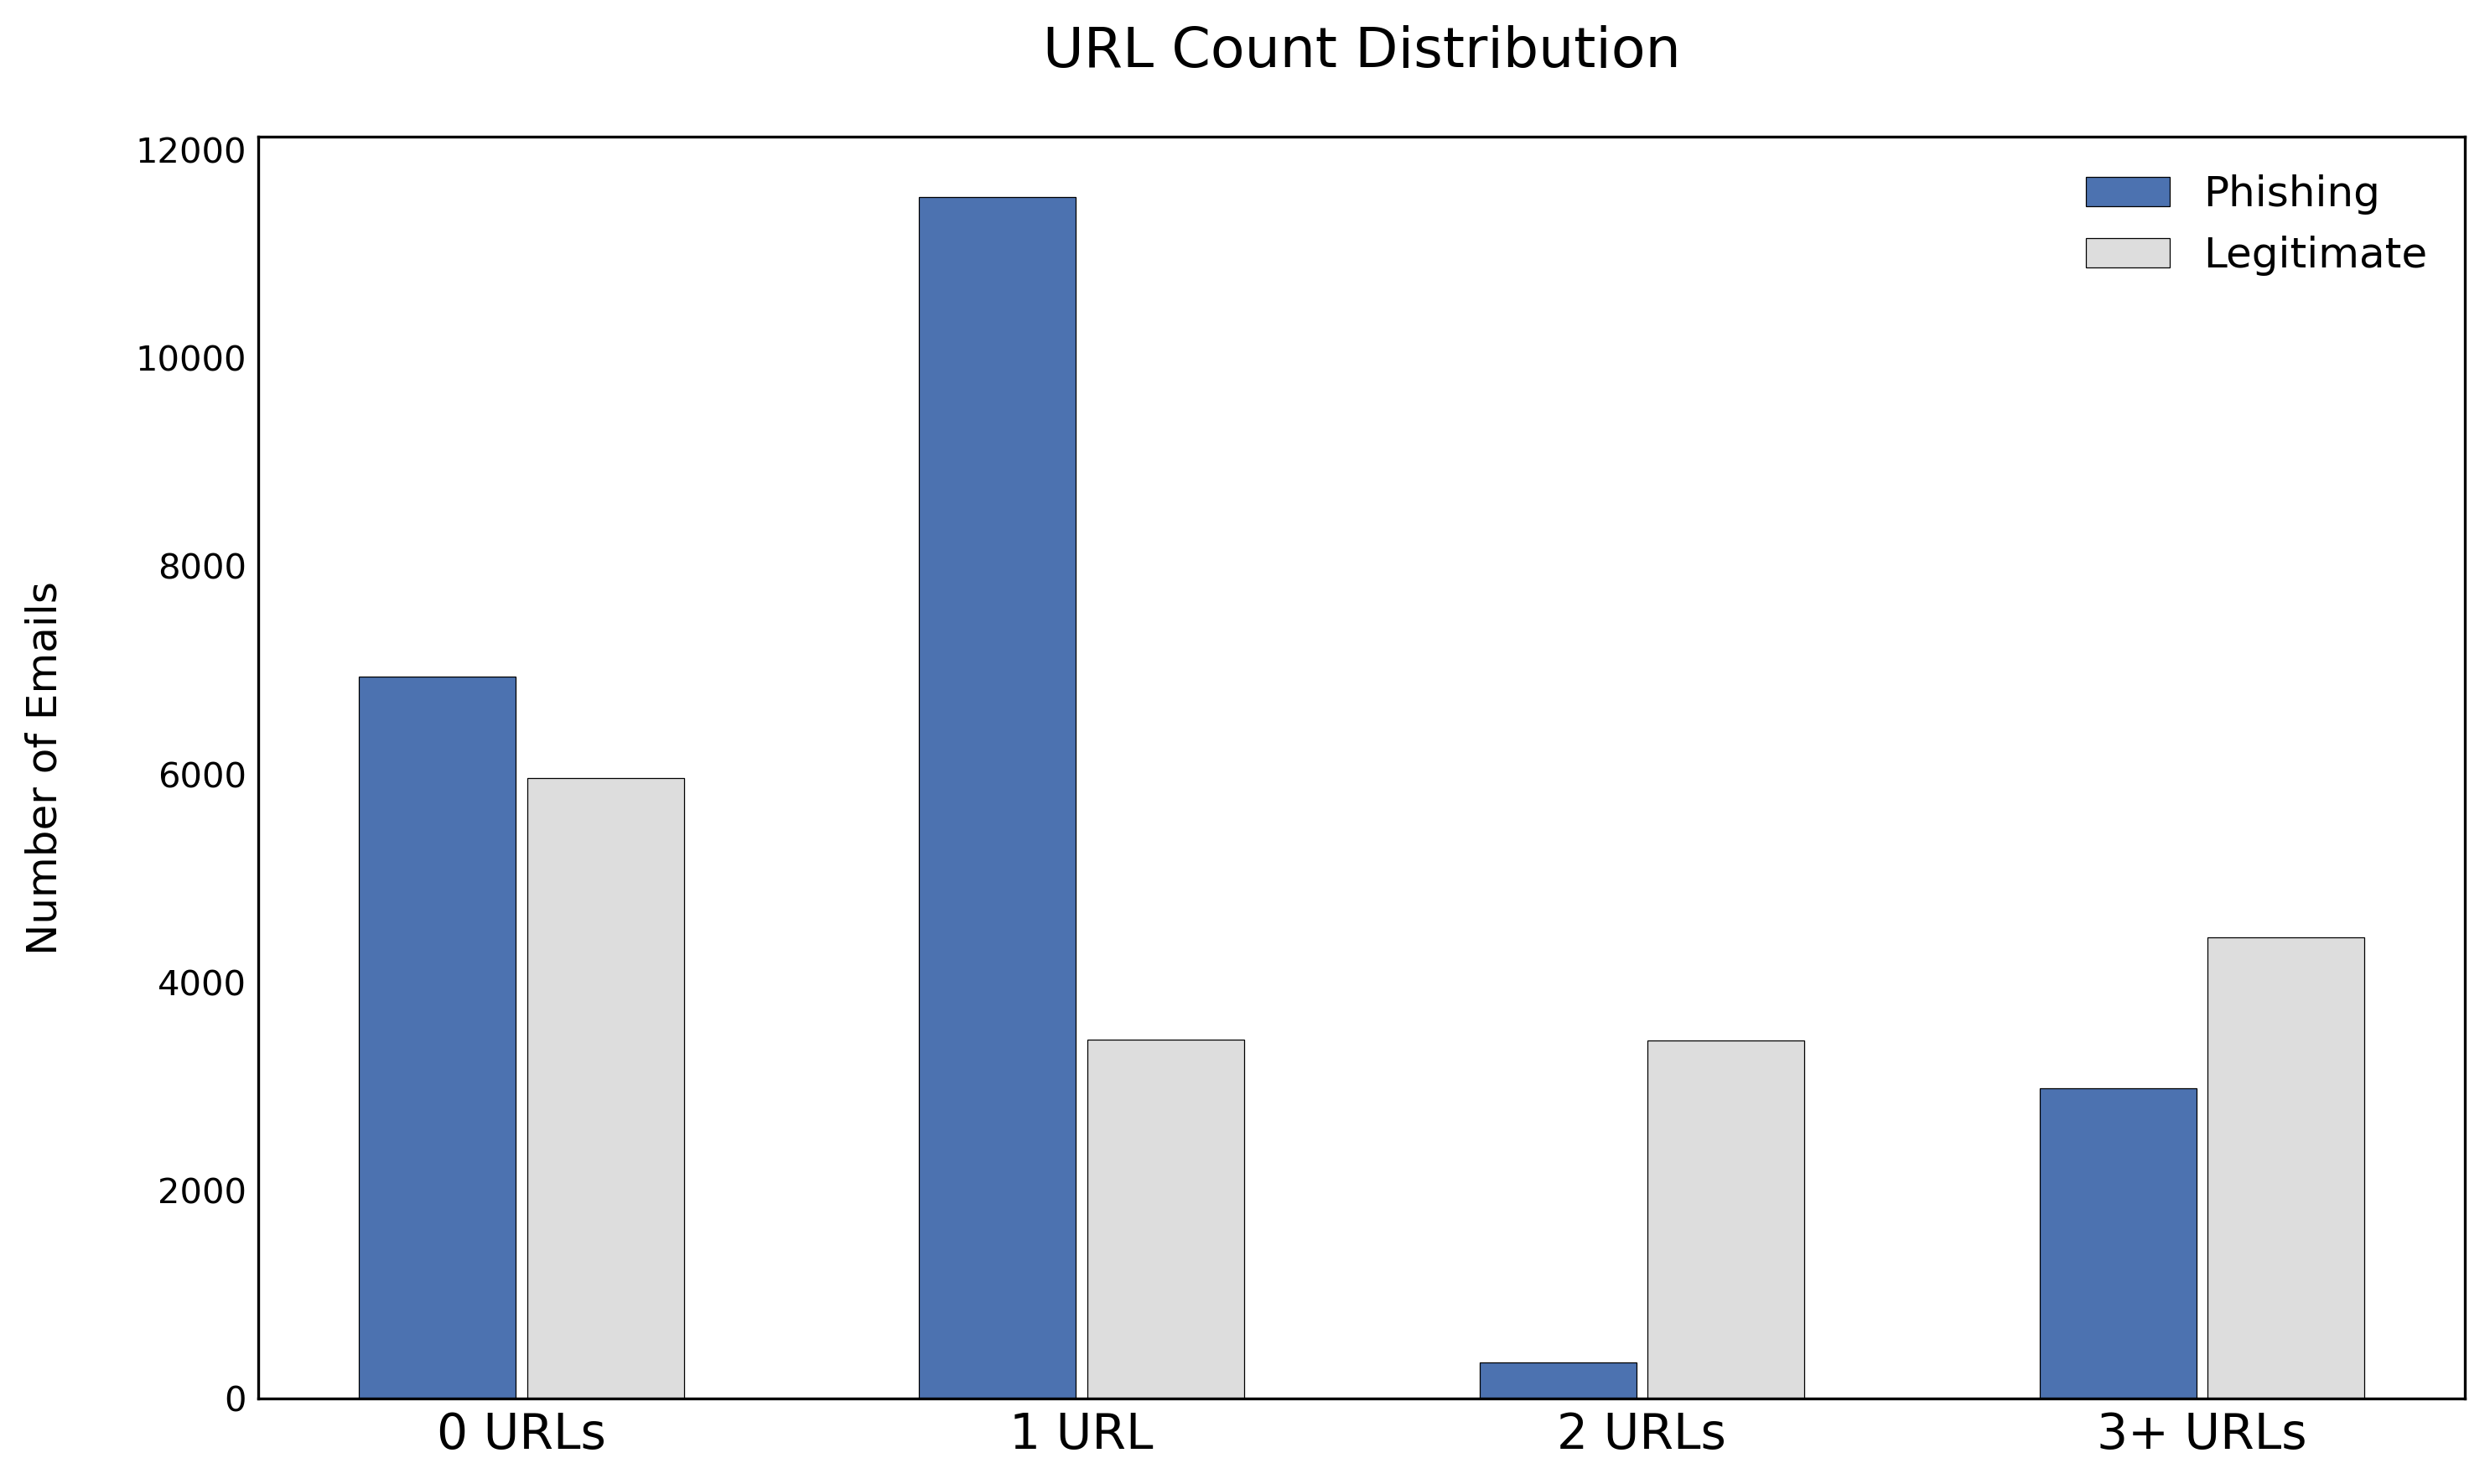

In [135]:
# URL Count Distribution

# Map numeric labels to readable text labels
label_names = {0: "Legitimate", 1: "Phishing"}
features_df["label_name"] = features_df["label"].map(label_names)

# Bucket emails based on number of URLs found
def bucket_urls(n):
    if n == 0:
        return "0 URLs"
    elif n == 1:
        return "1 URL"
    elif n == 2:
        return "2 URLs"
    else:
        return "3+ URLs"

# Apply URL bucket categories
features_df["url_bucket"] = features_df["num_urls"].apply(bucket_urls)

# Create a frequency table of URL buckets vs. email label
table = pd.crosstab(features_df["url_bucket"], features_df["label_name"])

# Ensure rows appear in defined logical order
bucket_order = ["0 URLs", "1 URL", "2 URLs", "3+ URLs"]
table = table.reindex(bucket_order)

# Create bar chart figure
fig, ax = plt.subplots(figsize=(10, 6), dpi=300) 

x = range(len(bucket_order))
width = 0.28                                      
offset = 0.15                                      

# Plot phishing email counts
ax.bar(
    [p - offset for p in x],
    table["Phishing"],
    width,
    label="Phishing",
    color=colors[0],
    edgecolor="black", linewidth=0.3    
)

# Plot legitimate email counts
ax.bar(
    [p + offset for p in x],
    table["Legitimate"],
    width,
    label="Legitimate",
    color=colors[1],
    edgecolor="black", linewidth=0.3
)

# Configure x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(bucket_order, fontsize=14)

# Chart title and axis label
ax.set_title("URL Count Distribution", fontsize=16, pad=20)
ax.set_ylabel("Number of Emails", fontsize=12, labelpad=20)

# Show legend
ax.legend(fontsize=12, frameon=False)

# Remove x-axis and y-axis tick marks
ax.minorticks_off()
ax.tick_params(axis='y', length=0)
ax.tick_params(axis='x', length=0)

plt.tight_layout()

# fig.savefig("url_count_distribution_clean.png", dpi=300, bbox_inches="tight")

plt.show()

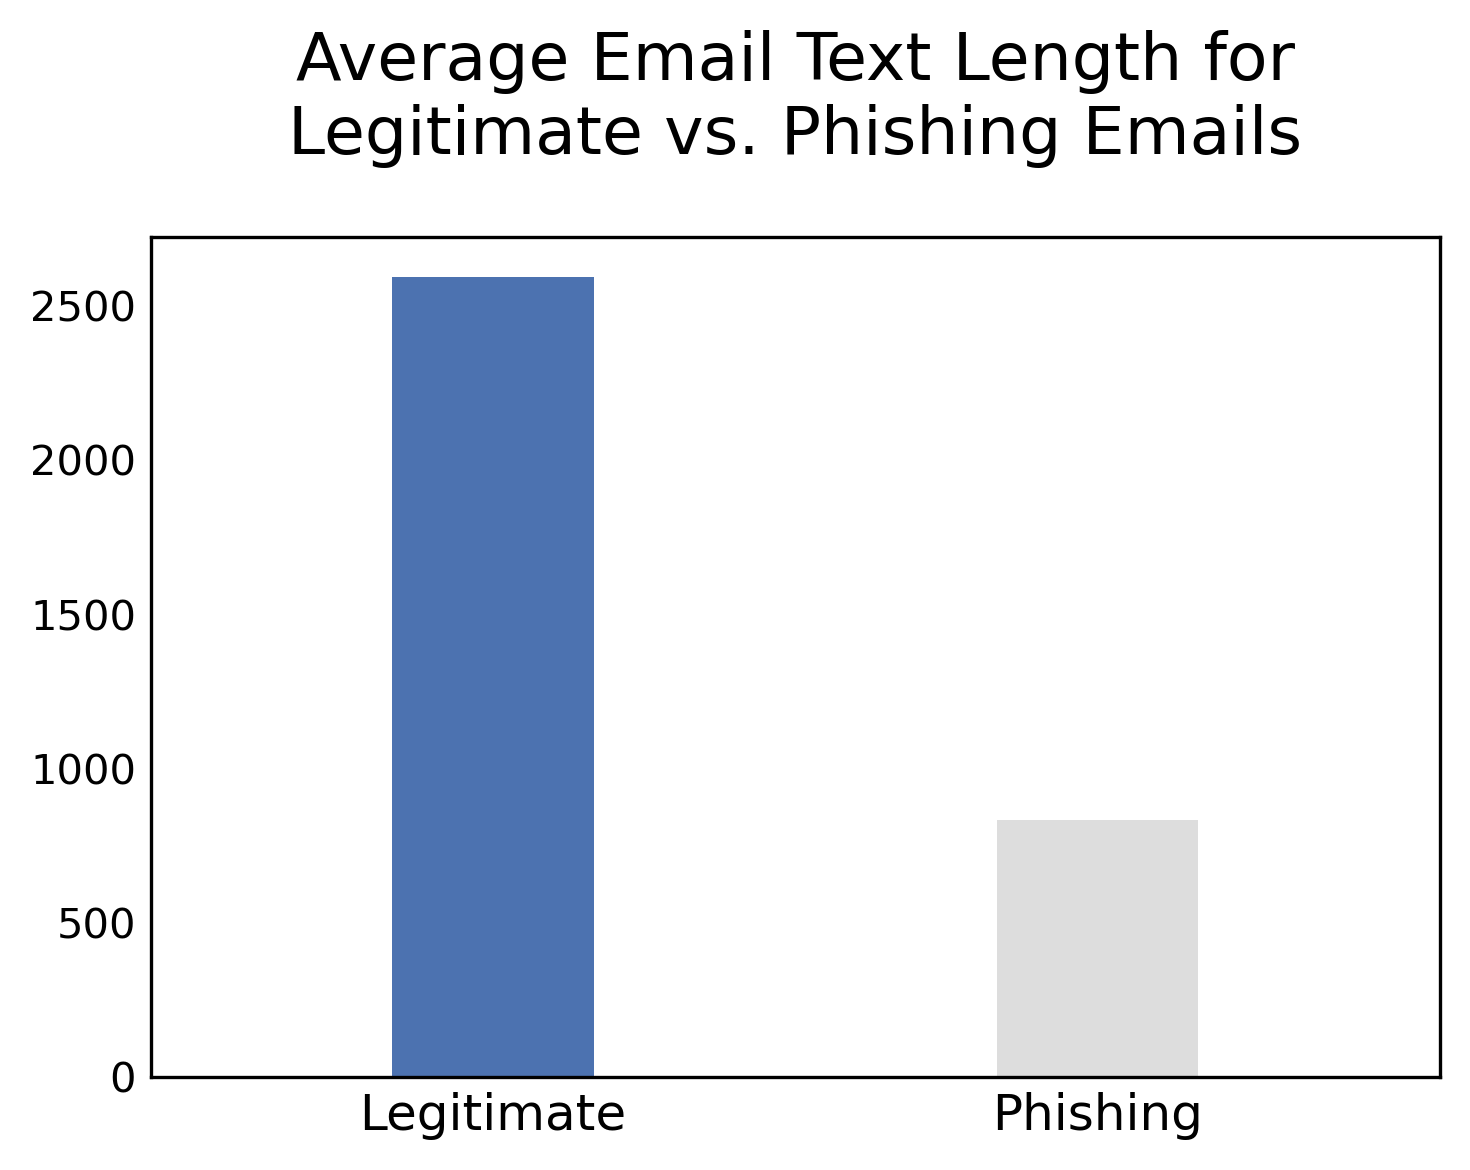

In [137]:
# Average Email Text Length 

# Calculate average text length for legitimate and phishing emails
avg_legit = features_df[features_df["label"] == 0]["text_length"].mean()
avg_phish = features_df[features_df["label"] == 1]["text_length"].mean()

categories = ["Legitimate", "Phishing"]
values = [avg_legit, avg_phish]


colors = ["#4C72B0", "#DDDDDD"]

# Set bar positions manually to control spacing
x = np.array([0, 0.3])

fig, ax = plt.subplots(figsize=(5, 4), dpi=300) 

# Bar chart
ax.bar(x, values, color=colors, width=0.10)

# Configure x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=12)

# Add margins to improve spacing around bars
ax.margins(x=0.3)

# Title
ax.set_title("Average Email Text Length for\nLegitimate vs. Phishing Emails", fontsize=16, pad=20)

# Remove tick marks for a cleaner look
ax.minorticks_off()
ax.tick_params(axis='y', length=0)
ax.tick_params(axis='x', length=0)

plt.tight_layout()

## fig.savefig("avg_text_length_bar.png", dpi=300, bbox_inches="tight")

plt.show()


In [ ]:
# Logistic Regression Model Training

# Build a pipeline: standardize features then apply Logistic Regression
logreg_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

In [ ]:
# Train the model on the final feature set
logreg_model.fit(X_train_final, y_labels_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [ ]:
# Predict labels on the test set
y_pred_logreg = logreg_model.predict(X_test_final)

In [ ]:
# Print main evaluation metrics
print("\n=== Logistic Regression Metrics ===")
print("Accuracy:", accuracy_score(y_labels_test, y_pred_logreg))
print("Precision:", precision_score(y_labels_test, y_pred_logreg))
print("Recall:", recall_score(y_labels_test, y_pred_logreg))
print("F1 Score:", f1_score(y_labels_test, y_pred_logreg))

print("\n=== Classification Report (Logistic Regression) ===")
print(classification_report(y_labels_test, y_pred_logreg))


=== Logistic Regression Metrics ===
Accuracy: 0.891898798875543
Precision: 0.8812824956672444
Recall: 0.9317453046266606
F1 Score: 0.905811623246493

=== Classification Report (Logistic Regression) ===
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      3460
           1       0.88      0.93      0.91      4366

    accuracy                           0.89      7826
   macro avg       0.89      0.89      0.89      7826
weighted avg       0.89      0.89      0.89      7826



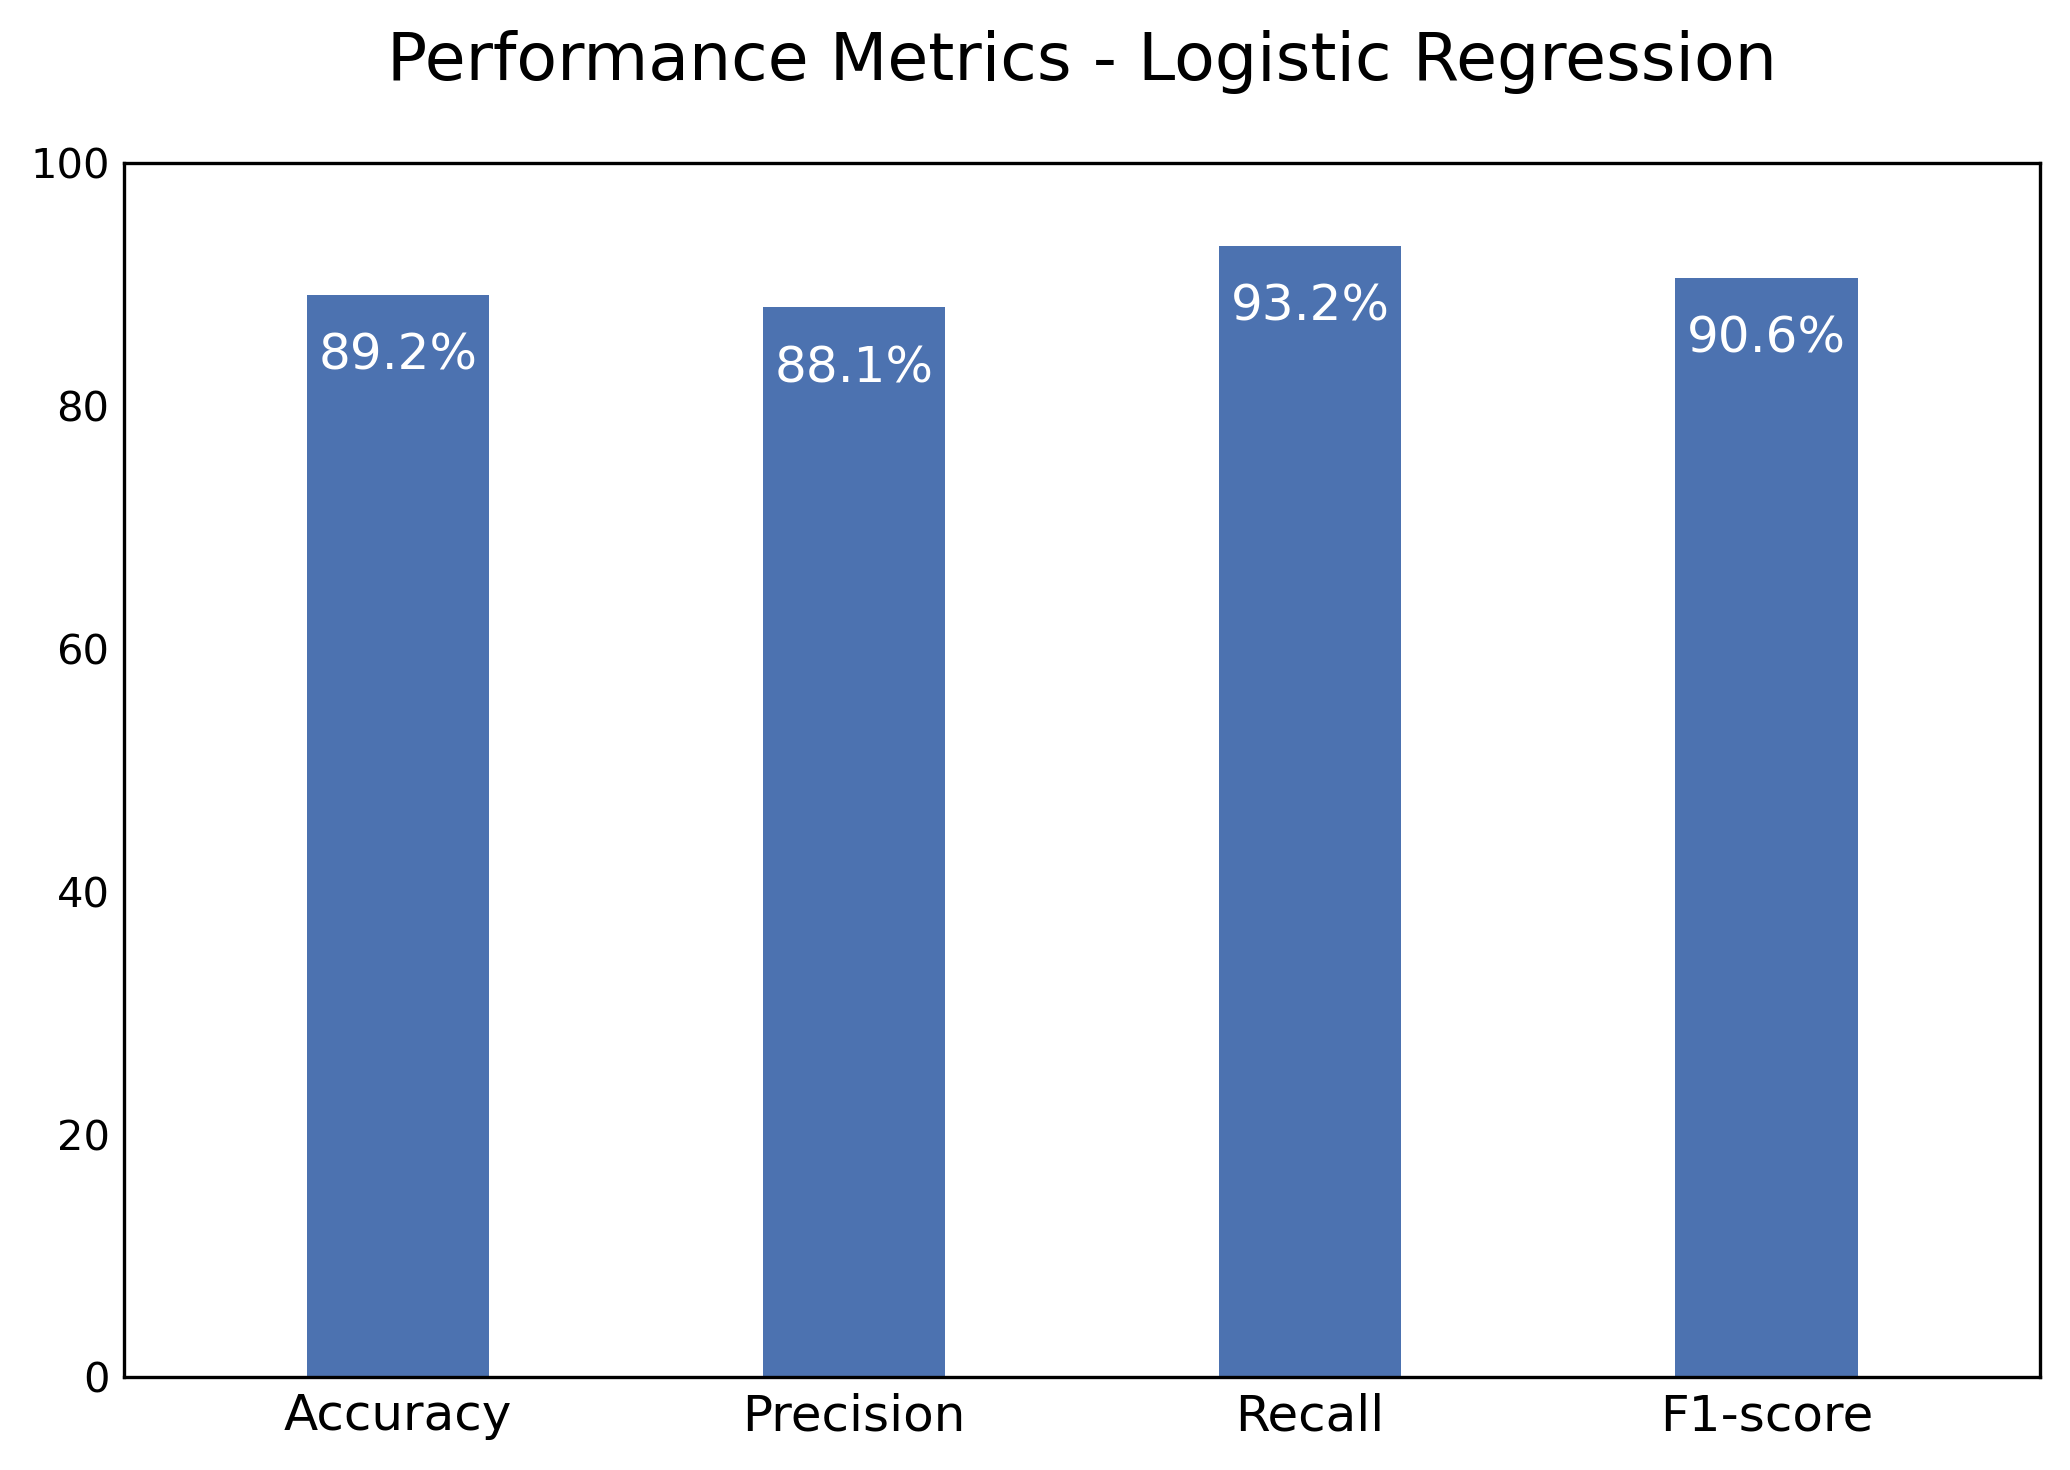

In [187]:
# Bar Chart of Overall Performance Metrics - Logistic Regression 

# Convert metrics to percentages for visualization
metrics = {
    "Accuracy":  accuracy_score(y_labels_test, y_pred_logreg) * 100,
    "Precision": precision_score(y_labels_test, y_pred_logreg) * 100,
    "Recall":    recall_score(y_labels_test, y_pred_logreg) * 100,
    "F1-score":  f1_score(y_labels_test, y_pred_logreg) * 100,
}

names  = list(metrics.keys())
values = list(metrics.values())

fig, ax = plt.subplots(figsize=(7, 5), dpi=300)


bar_width = 0.40

# Bar positions
x = np.arange(len(names)) 

# Draw bars for each metric
bars = ax.bar(
    x,
    values,
    width=bar_width,
    color="#4C72B0"
)

# Add percentage labels inside each bar
for bar, val in zip(bars, values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() - 5,
        f"{val:.1f}%",
        ha="center",
        va="center",
        fontsize=12,
        color="white",
    )

# Configure axes
ax.set_ylim(0, 100)
ax.set_xticks(x)
ax.set_xticklabels(names, fontsize=12)

ax.set_title("Performance Metrics - Logistic Regression", fontsize=16, pad=20)

# Remove tick marks for cleaner look
ax.minorticks_off()
ax.tick_params(axis='y', length=0)
ax.tick_params(axis='x', length=0)

# Add margin so bars are not touching the plot borders
plt.xlim(-0.6, len(names) - 0.4)

plt.tight_layout()
plt.show()

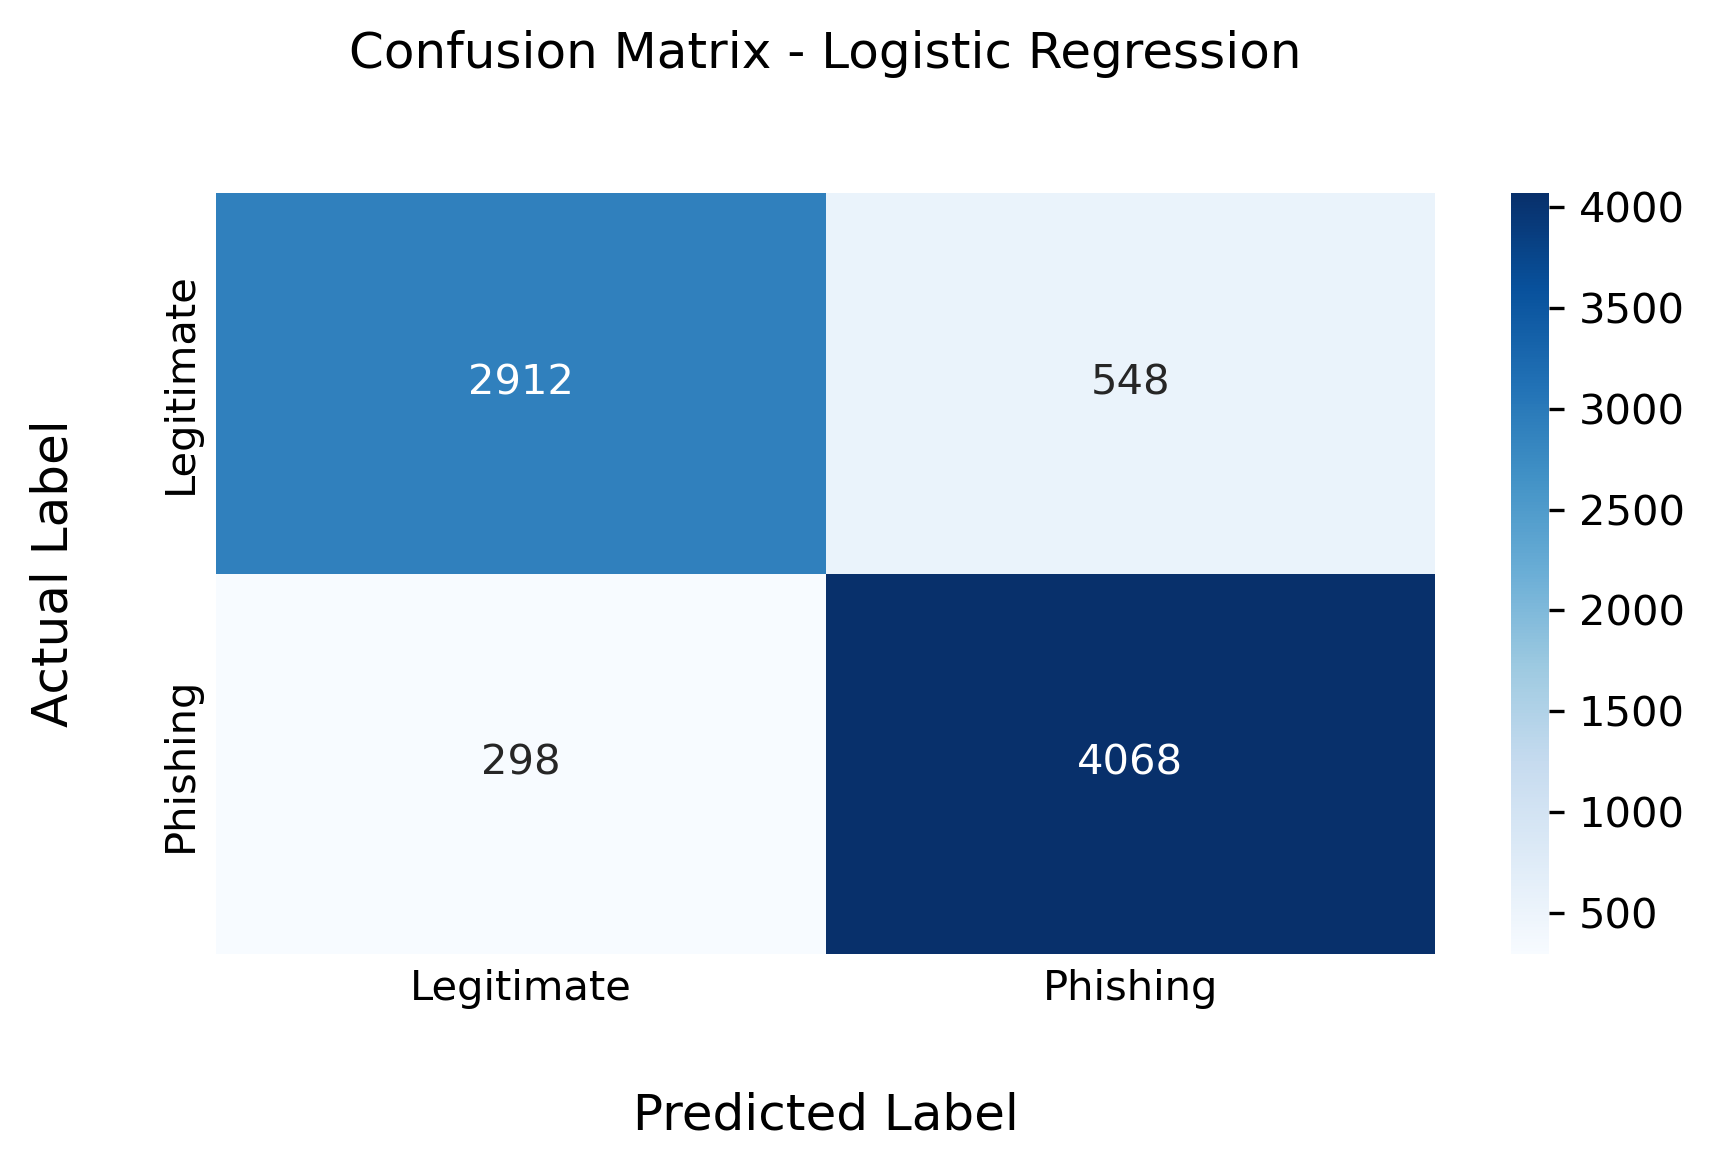

In [200]:
# Confusion Matrix (Heatmap)

cm_logreg = confusion_matrix(y_labels_test, y_pred_logreg)

fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

# Plot confusion matrix as a heatmap
sns.heatmap(
    cm_logreg,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=ax
)

ax.set_title("Confusion Matrix - Logistic Regression", pad=30)
ax.set_xlabel("Predicted Label", fontsize=12, labelpad=20)
ax.set_ylabel("Actual Label", fontsize=12, labelpad=20)

ax.set_xticklabels(["Legitimate", "Phishing"])
ax.set_yticklabels(["Legitimate", "Phishing"])

# Remove tick marks
ax.minorticks_off()
ax.tick_params(axis='y', length=0)
ax.tick_params(axis='x', length=0)

plt.tight_layout()
plt.show()

In [ ]:
# Feature Importance (Logistic Regression Coefficients)

# Get the trained classifier from the pipeline
clf = logreg_model.named_steps["clf"]

feature_names = X_train_final.columns
coeffs = clf.coef_[0]

# Pair feature names with their coefficients and sort by absolute value
feature_importance_logreg = sorted(
    zip(feature_names, coeffs),
    key=lambda x: abs(x[1]),
    reverse=True
)

# Print top 20 most influential features
for name, coef in feature_importance_logreg[:20]:
    print(f"{name:25s}  coef = {coef:.4f}")

text_length                coef = -14.1148
num_urls                   coef = 4.5139
has_at_symbol              coef = 1.5322
exclamation_count          coef = 1.1982
max_url_length             coef = -0.9093
many_subdomains            coef = -0.8596
sender_is_free_provider    coef = -0.8383
has_dash_in_domain         coef = -0.3372
uppercase_ratio            coef = 0.2230
sender_has_numbers         coef = 0.2131
sender_domain_length       coef = 0.1591
urgent_word_count          coef = 0.1542
has_hex_string             coef = -0.1128
has_suspicious_tld         coef = 0.0564
has_ip_in_url              coef = -0.0464
sender_has_dash            coef = 0.0034


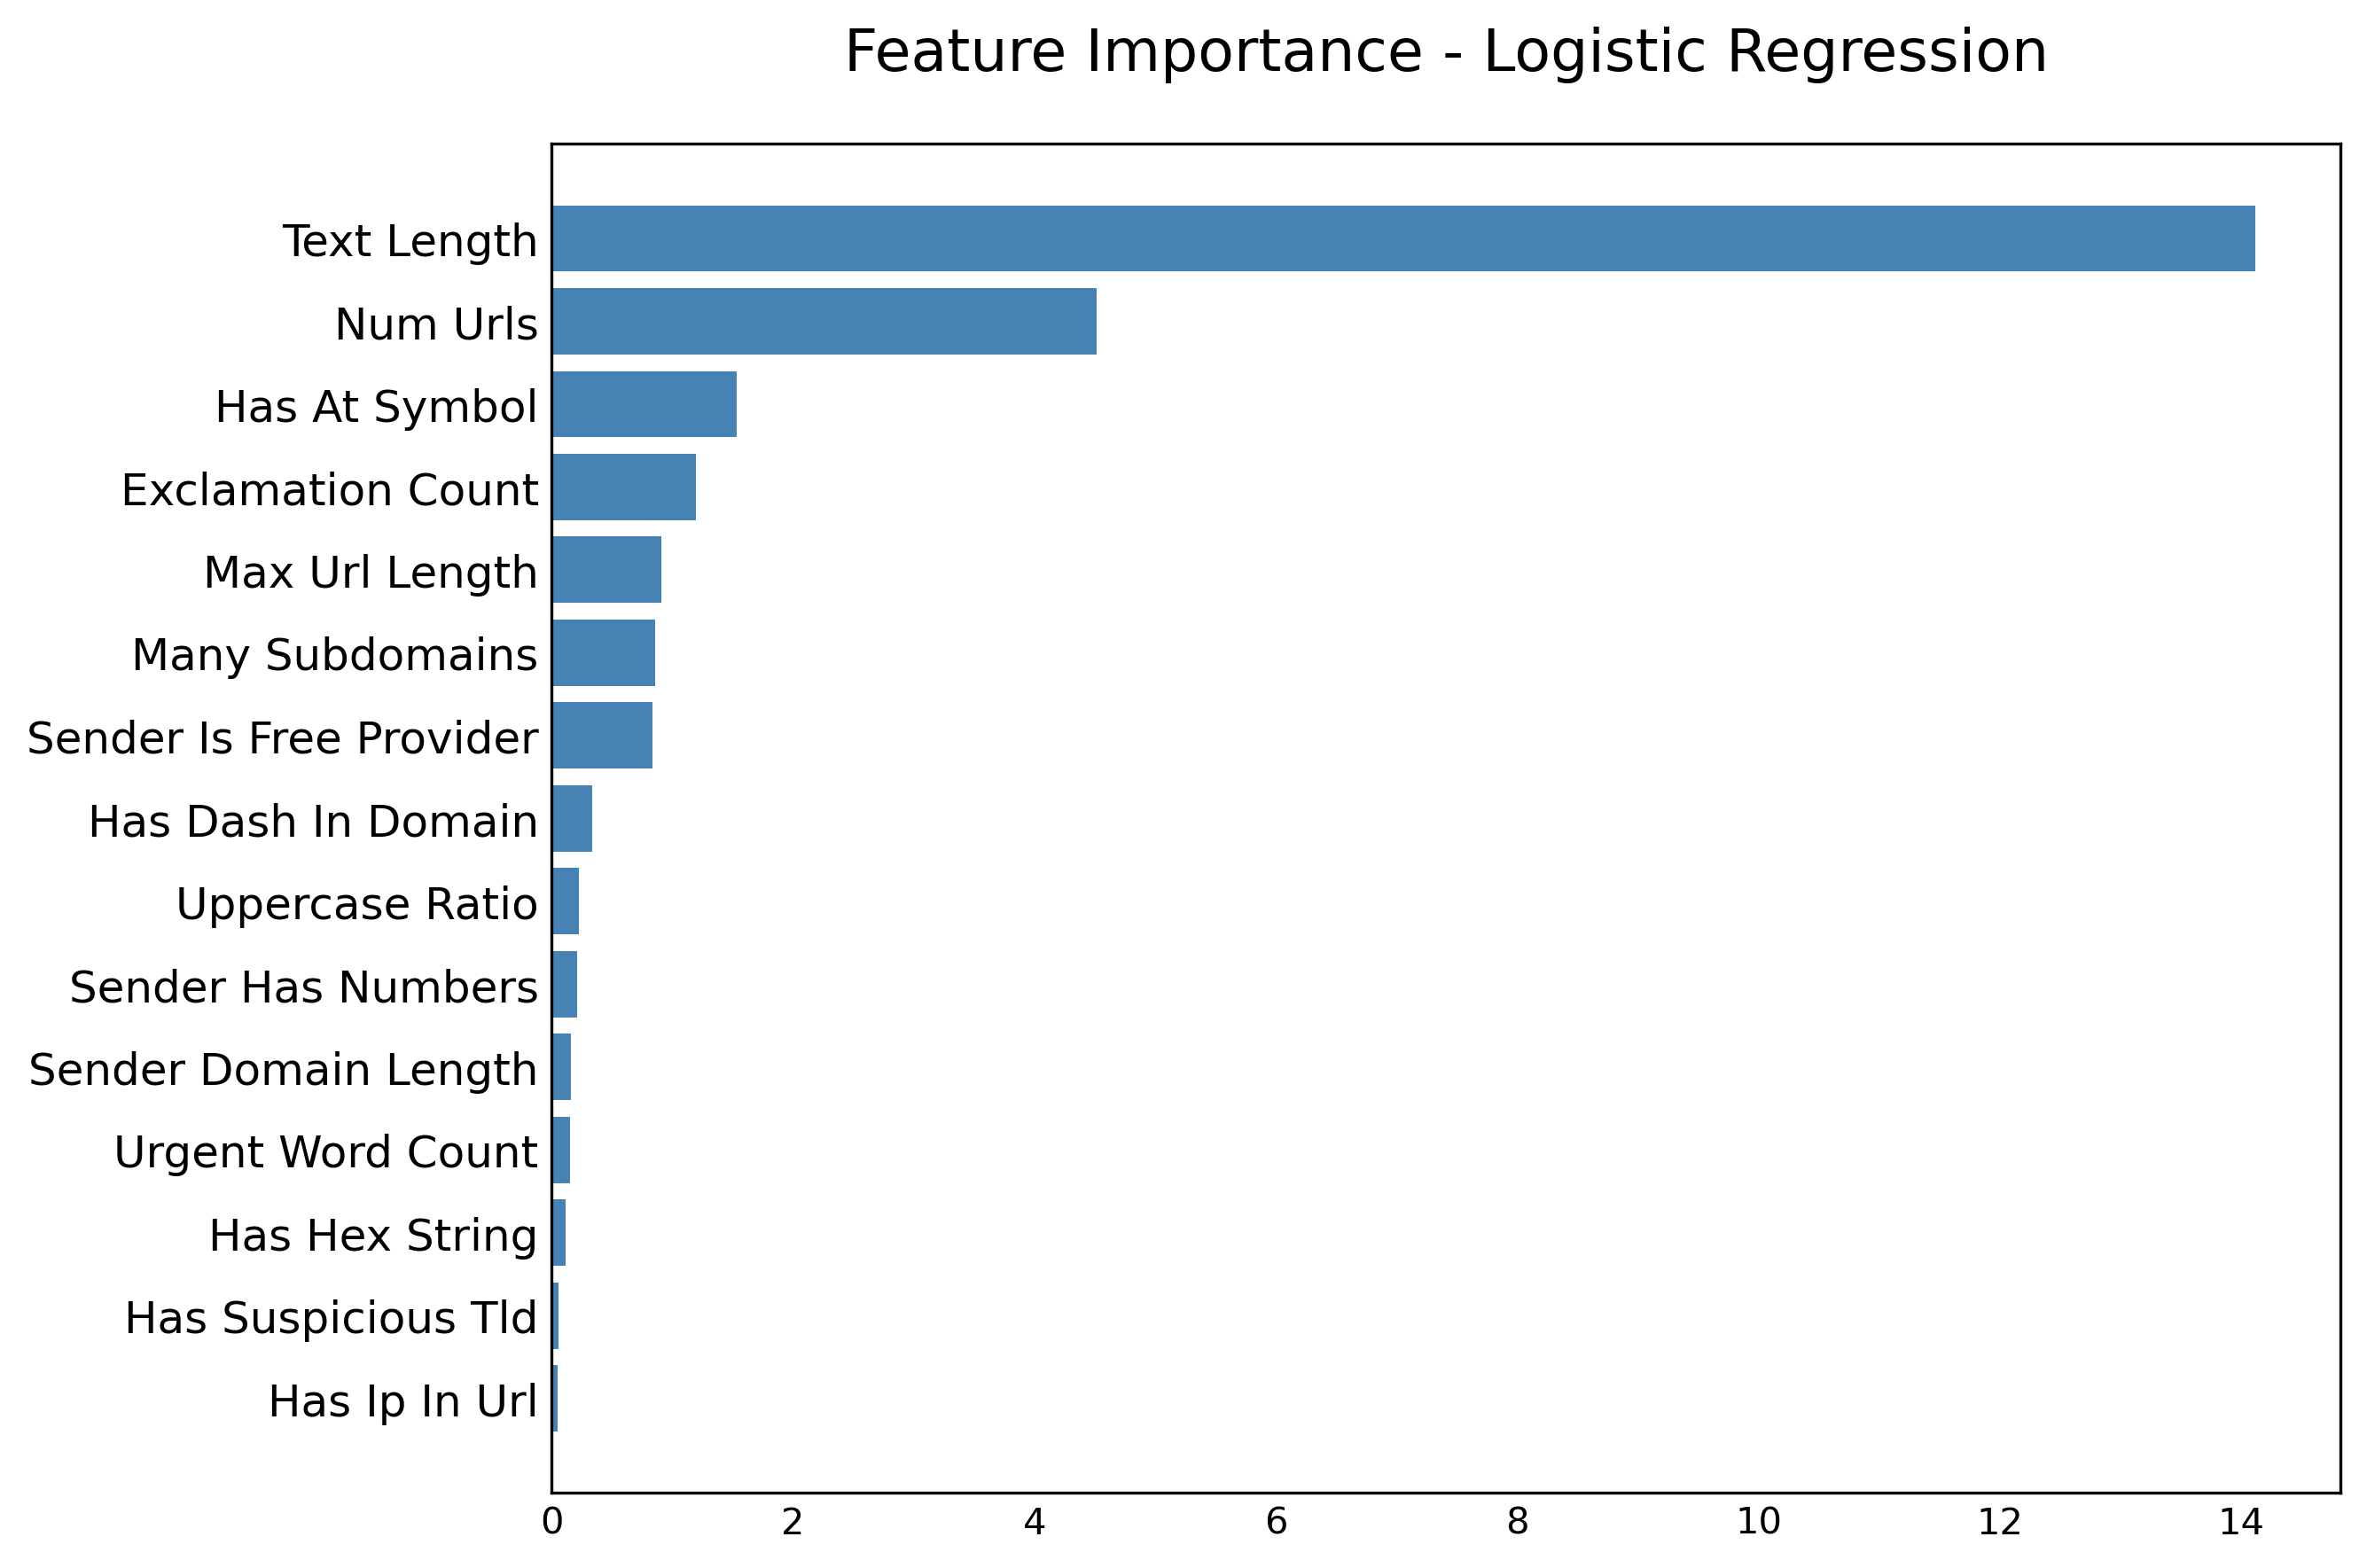

In [195]:
# Prepare data for feature importance bar chart
coef_values = np.abs(coeffs)
sorted_idx = np.argsort(coef_values)[::-1]
sorted_features = feature_names[sorted_idx]
sorted_coeffs = coef_values[sorted_idx]

# Clean labels for readability
clean_features = [feature.replace("_", " ").title() for feature in sorted_features[:15]]

fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

# Horizontal bar chart of top 15 most important features
ax.barh(clean_features, sorted_coeffs[:15], color='steelblue')

# Highest importance at the top
ax.invert_yaxis()  

# Titles and labels
ax.set_title("Feature Importance - Logistic Regression", fontsize=16, pad=20)

# Remove tick marks
ax.tick_params(axis='y', length=0, labelsize=12)
ax.tick_params(axis='x', length=0)

plt.tight_layout()

# Save high-resolution image
## fig.savefig("logreg_feature_importance.png", dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
# Random Forest Model Training

# Initialize Random Forest classifier with basic settings
rf_model = RandomForestClassifier(
    n_estimators=200,      # Number of trees in the forest
    max_depth=None,       # Allow trees to grow fully
    class_weight="balanced",  # handle imbalance
    random_state=42,
    n_jobs=-1             # Use all CPU cores for faster training
)

In [ ]:
# Train the Random Forest model
rf_model.fit(X_train_final, y_labels_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

In [ ]:
# Predict on the test set
y_pred_rf = rf_model.predict(X_test_final)

In [ ]:
# Print main evaluation metrics
print("\n=== Random Forest Metrics ===")
print("Accuracy:", accuracy_score(y_labels_test, y_pred_rf))
print("Precision:", precision_score(y_labels_test, y_pred_rf))
print("Recall:", recall_score(y_labels_test, y_pred_rf))
print("F1 Score:", f1_score(y_labels_test, y_pred_rf))

print("\n=== Classification Report (Random Forest) ===")
print(classification_report(y_labels_test, y_pred_rf))


=== Random Forest Metrics ===
Accuracy: 0.9778941988244314
Precision: 0.982064842492527
Recall: 0.978240952817224
F1 Score: 0.9801491681009753

=== Classification Report (Random Forest) ===
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3460
           1       0.98      0.98      0.98      4366

    accuracy                           0.98      7826
   macro avg       0.98      0.98      0.98      7826
weighted avg       0.98      0.98      0.98      7826



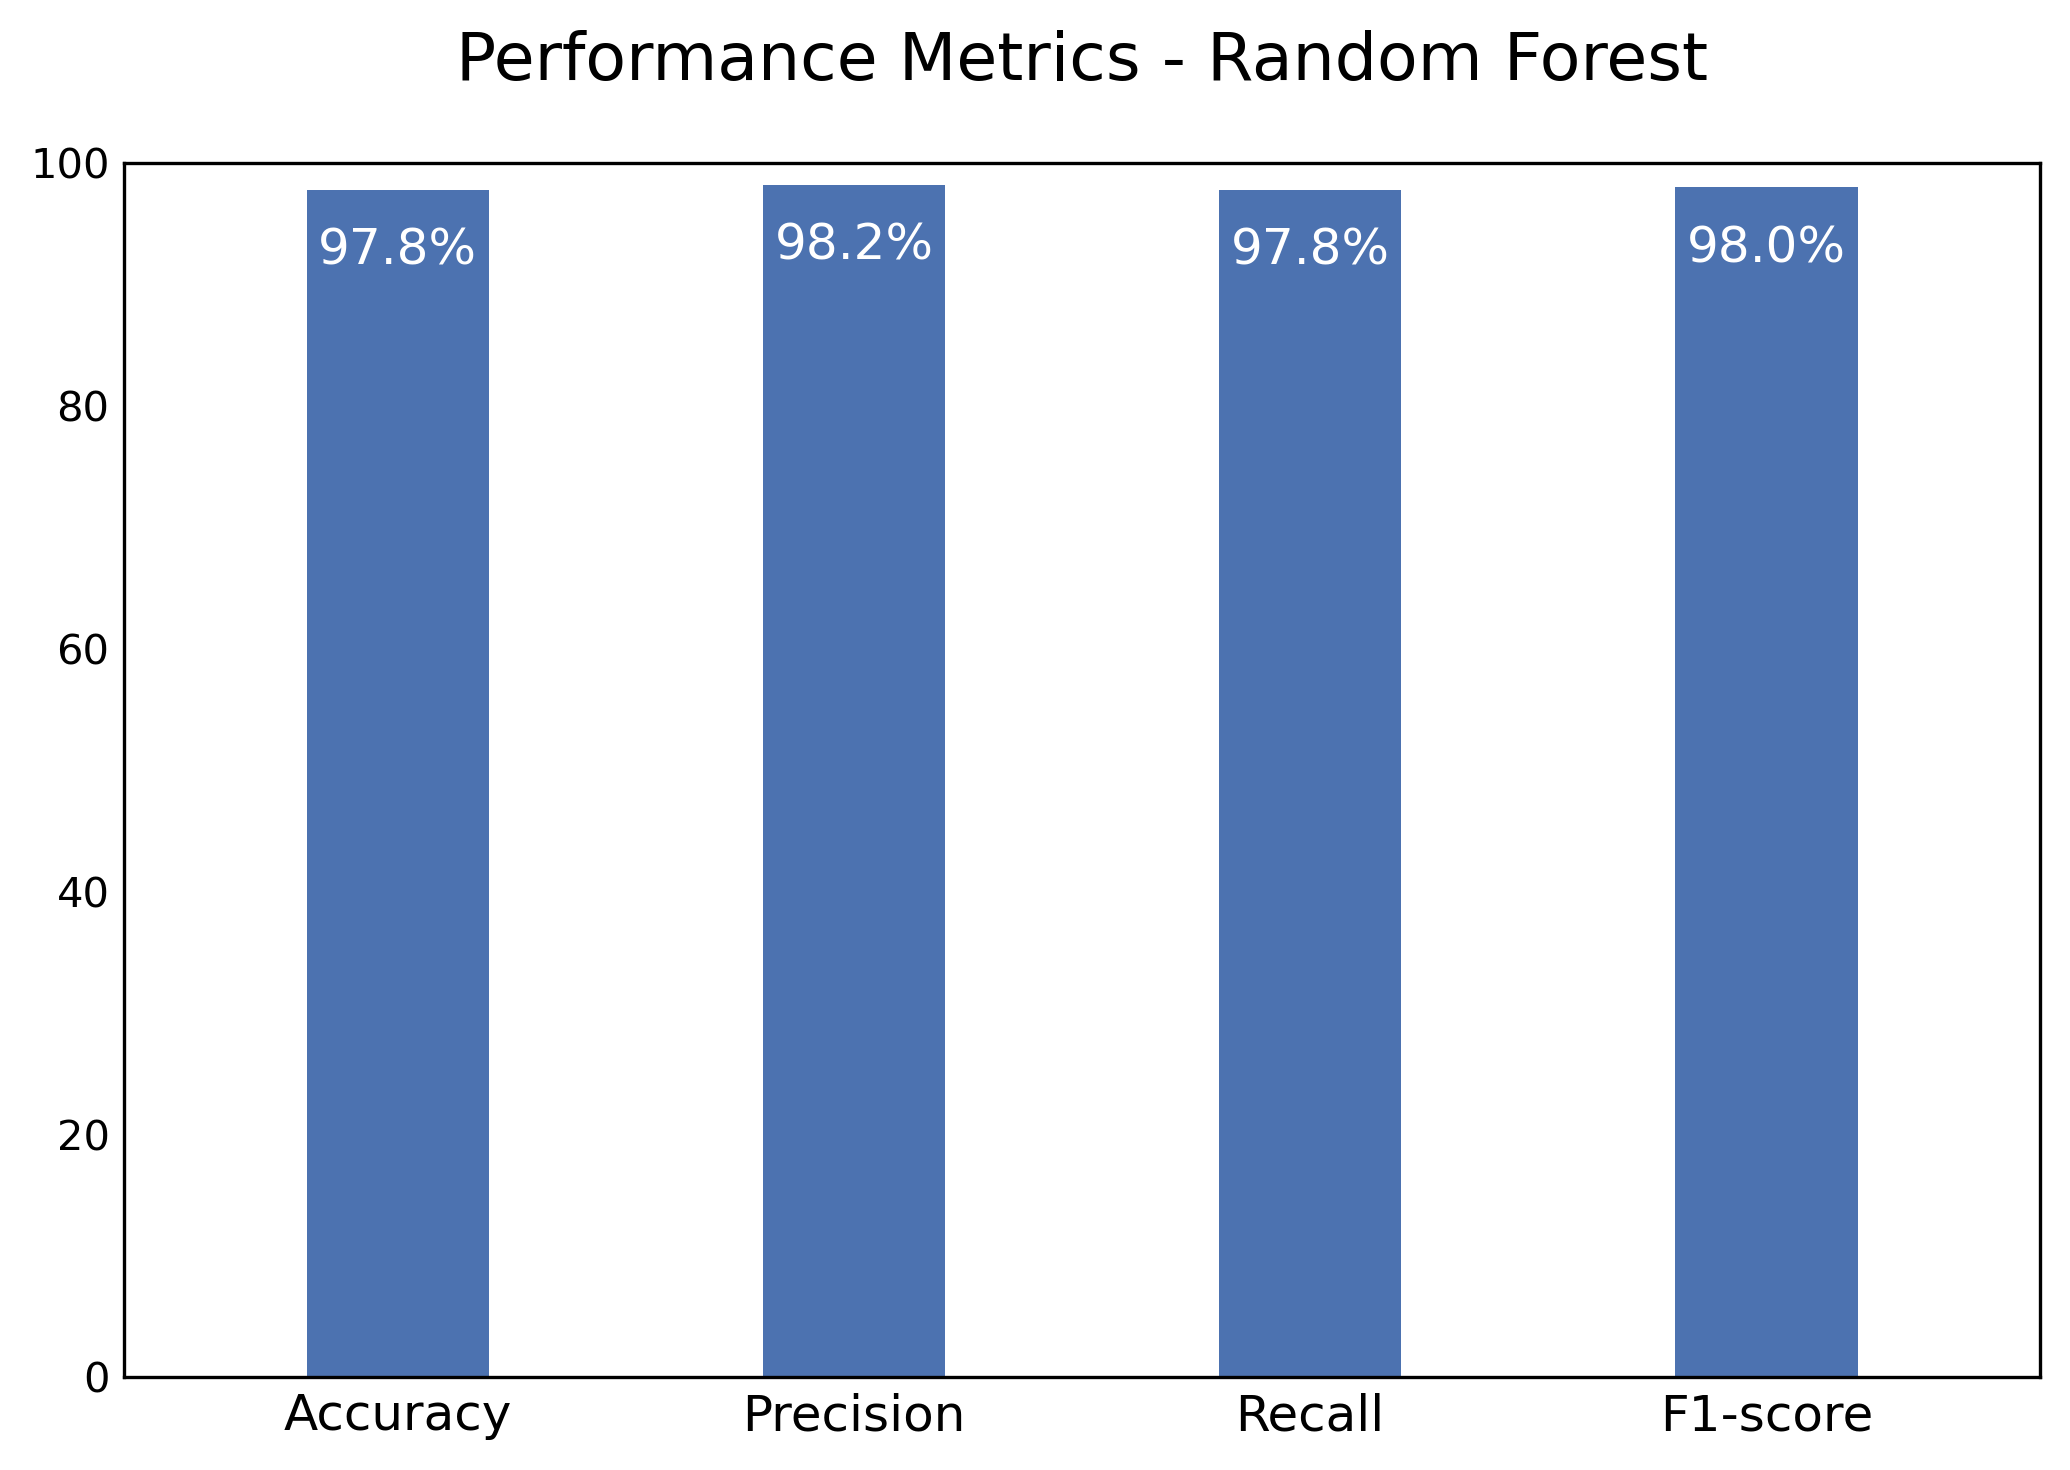

In [ ]:
# Bar Chart of Overall Performance Metrics - Random Forest

# Convert metrics to percentages for visualization
rf_metrics = {
    "Accuracy":  accuracy_score(y_labels_test, y_pred_rf) * 100,
    "Precision": precision_score(y_labels_test, y_pred_rf) * 100,
    "Recall":    recall_score(y_labels_test, y_pred_rf) * 100,
    "F1-score":  f1_score(y_labels_test, y_pred_rf) * 100,
}

names  = list(rf_metrics.keys())
values = list(rf_metrics.values())

fig, ax = plt.subplots(figsize=(7, 5), dpi=300)

# Bar positions and width
x = np.arange(len(names))
bar_width = 0.40

# Draw bars for each metric
bars = ax.bar(x, values, width=bar_width, color="#4C72B0")

# Add percentage labels inside the bar
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() - 5,
        f"{val:.1f}%",
        ha="center",
        va="center",
        fontsize=12,
        color="white",
    )

# Configure axes and labels
ax.set_ylim(0, 100)
ax.set_xticks(x)
ax.set_xticklabels(names, fontsize=12)
ax.set_title("Performance Metrics - Random Forest", fontsize=16, pad=20)

# Add margin so bars are not touching the plot borders
plt.xlim(-0.6, len(names) - 0.4)

# Remove tick marks
ax.minorticks_off()
ax.tick_params(axis='y', length=0)
ax.tick_params(axis='x', length=0)

plt.tight_layout()

## fig.savefig("rf_metrics_percentage.png", dpi=300, bbox_inches="tight")

plt.show()


In [ ]:
# Feature Importance (Random Forest)
importances = rf_model.feature_importances_

# Get feature importance scores from the trained model
feature_importance_rf = sorted(
    zip(X_train_final.columns, importances),
    key=lambda x: x[1],
    reverse=True
)

# Print top 20 most important features
for name, score in feature_importance_rf[:20]:
    print(f"{name:25s} importance = {score:.4f}")

text_length               importance = 0.4101
uppercase_ratio           importance = 0.1605
max_url_length            importance = 0.1512
num_urls                  importance = 0.0940
exclamation_count         importance = 0.0413
sender_is_free_provider   importance = 0.0381
has_at_symbol             importance = 0.0321
sender_domain_length      importance = 0.0292
urgent_word_count         importance = 0.0267
has_hex_string            importance = 0.0087
sender_has_numbers        importance = 0.0031
has_dash_in_domain        importance = 0.0019
sender_has_dash           importance = 0.0017
has_suspicious_tld        importance = 0.0011
has_ip_in_url             importance = 0.0001
many_subdomains           importance = 0.0001


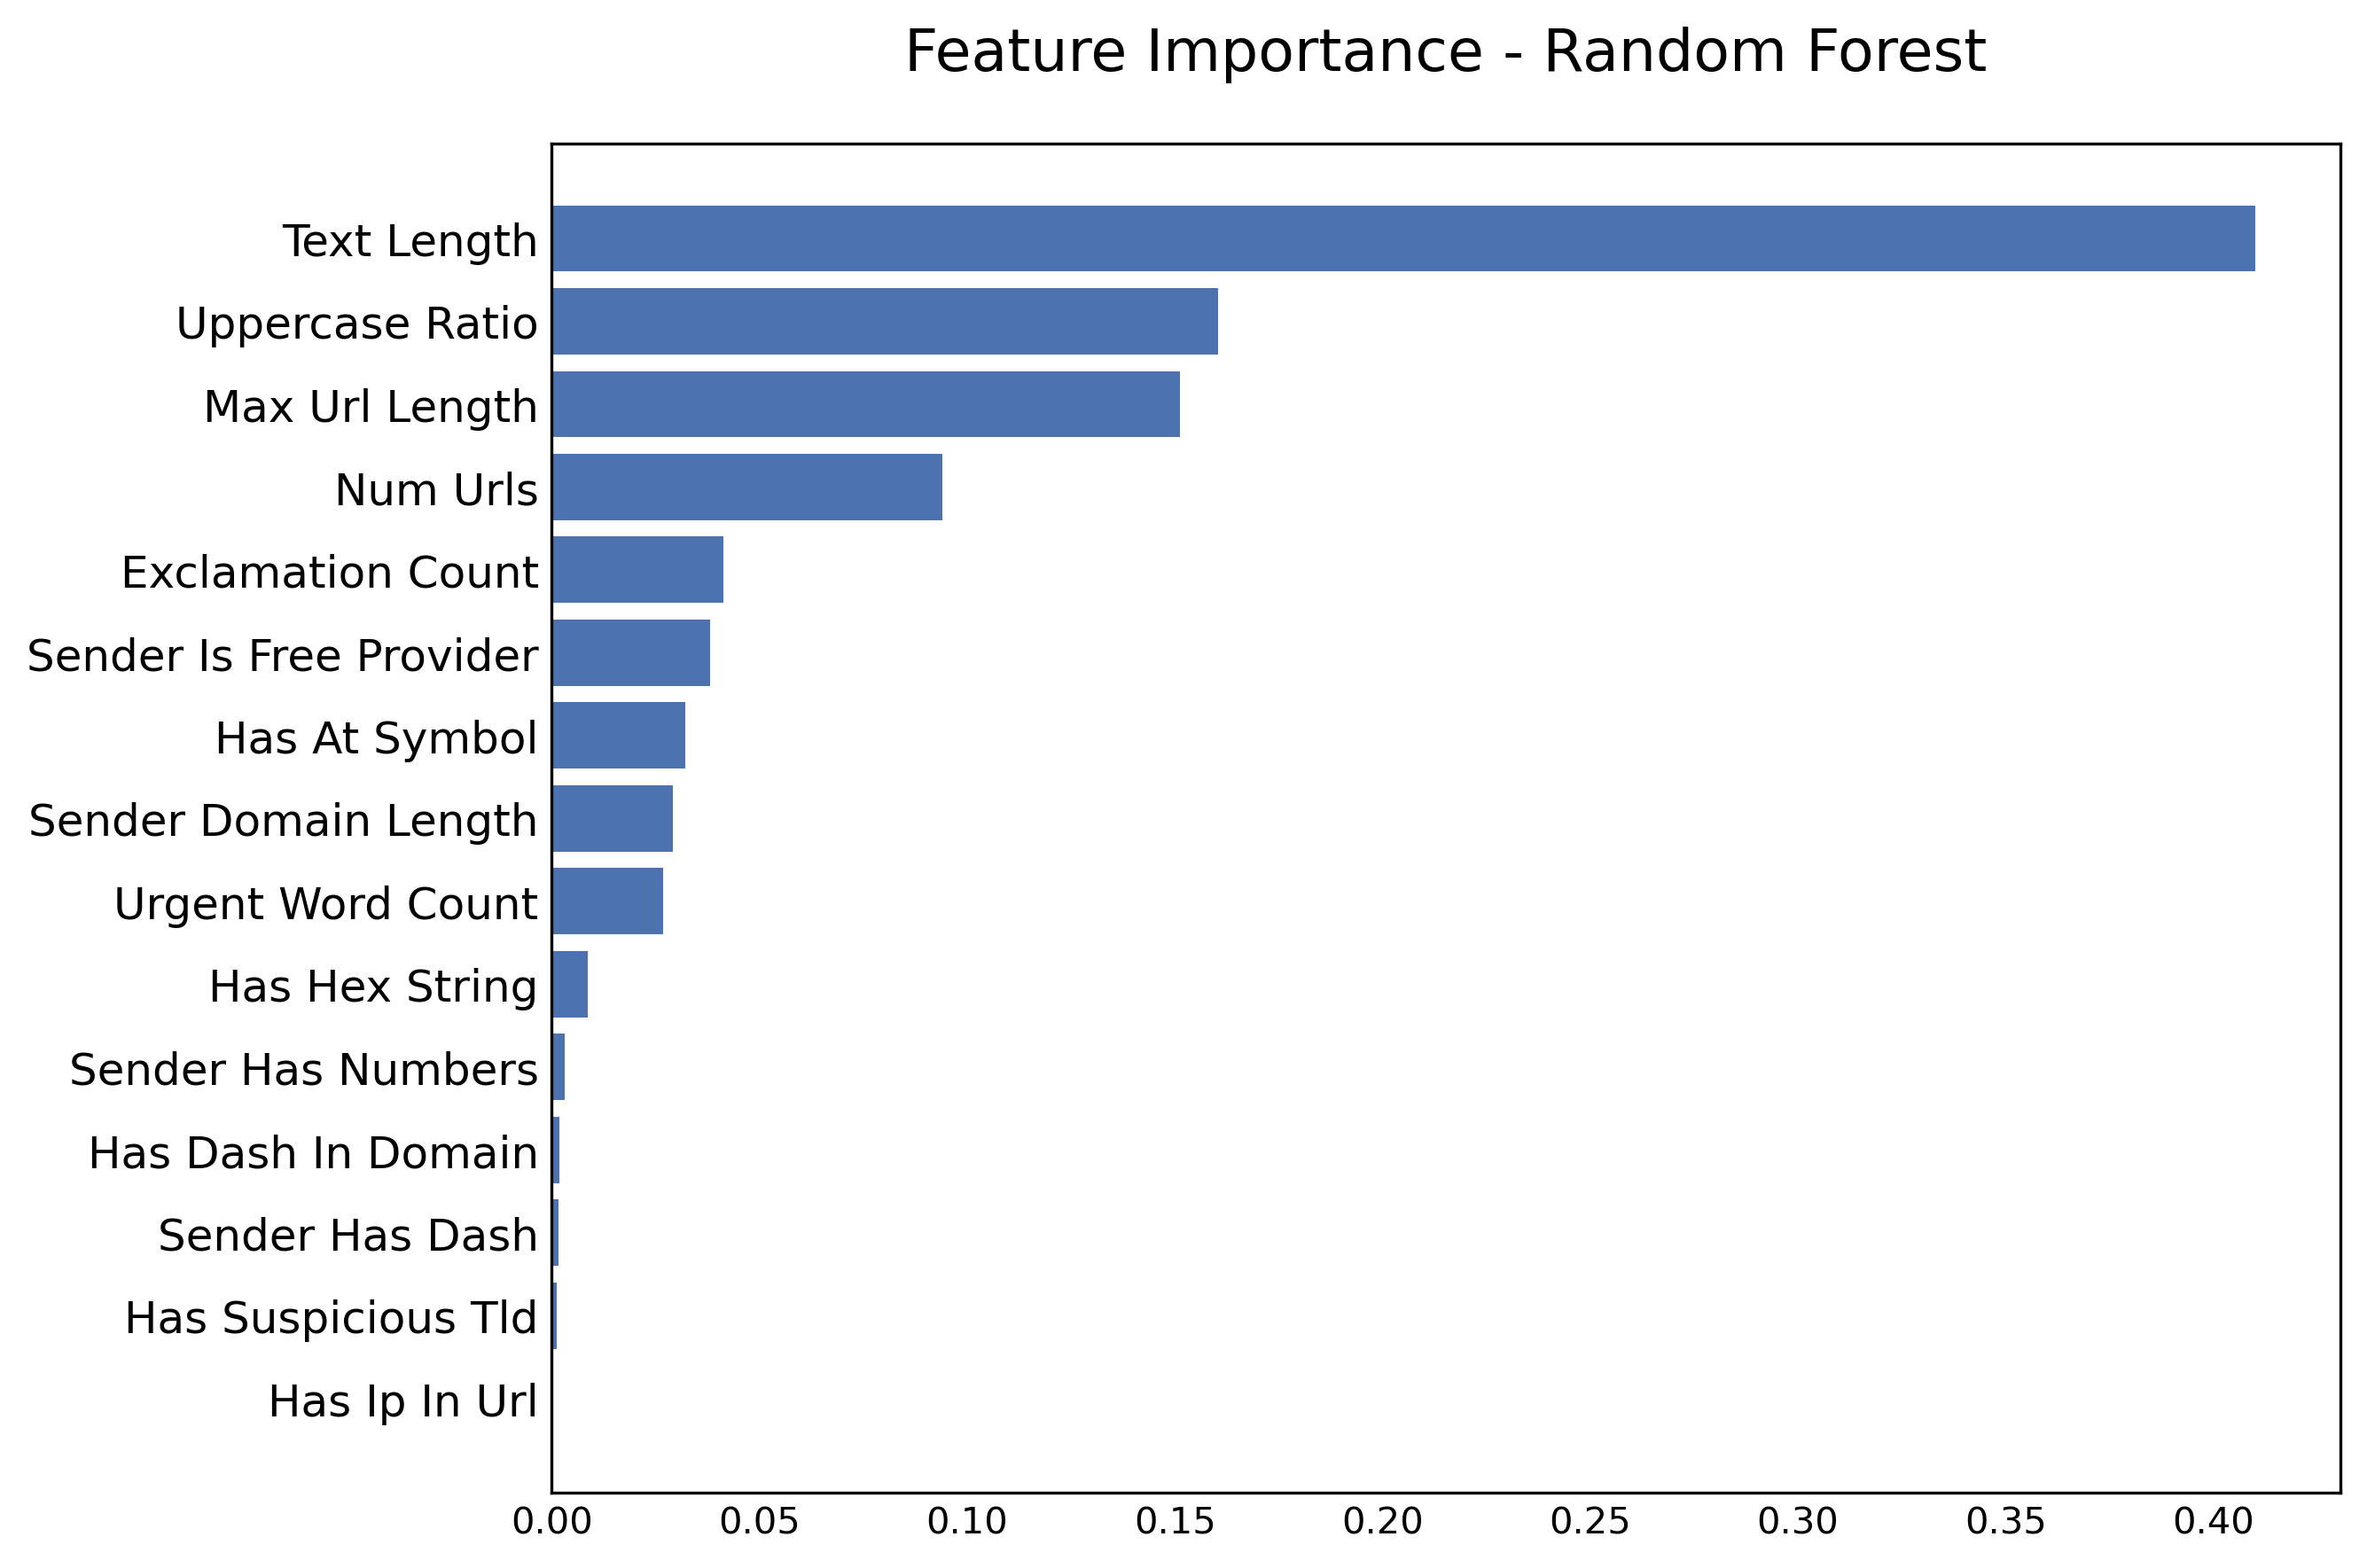

In [ ]:
feature_names = X_train_final.columns

# Sort features by importance
sorted_idx = np.argsort(importances)[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importances = importances[sorted_idx]

# Clean feature names for readability
clean_features = [f.replace("_", " ").title() for f in sorted_features[:15]]

fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

# Horizontal bar chart of top 15 features
ax.barh(clean_features, sorted_importances[:15], color="#4C72B0")

# Show most important features at the top
ax.invert_yaxis()

ax.set_title("Feature Importance - Random Forest", fontsize=16, pad=20)

# Remove tick marks
ax.tick_params(axis='y', length=0, labelsize=12)
ax.tick_params(axis='x', length=0)

plt.tight_layout()

# fig.savefig("rf_feature_importance_top15.png", dpi=300, bbox_inches="tight")

plt.show()

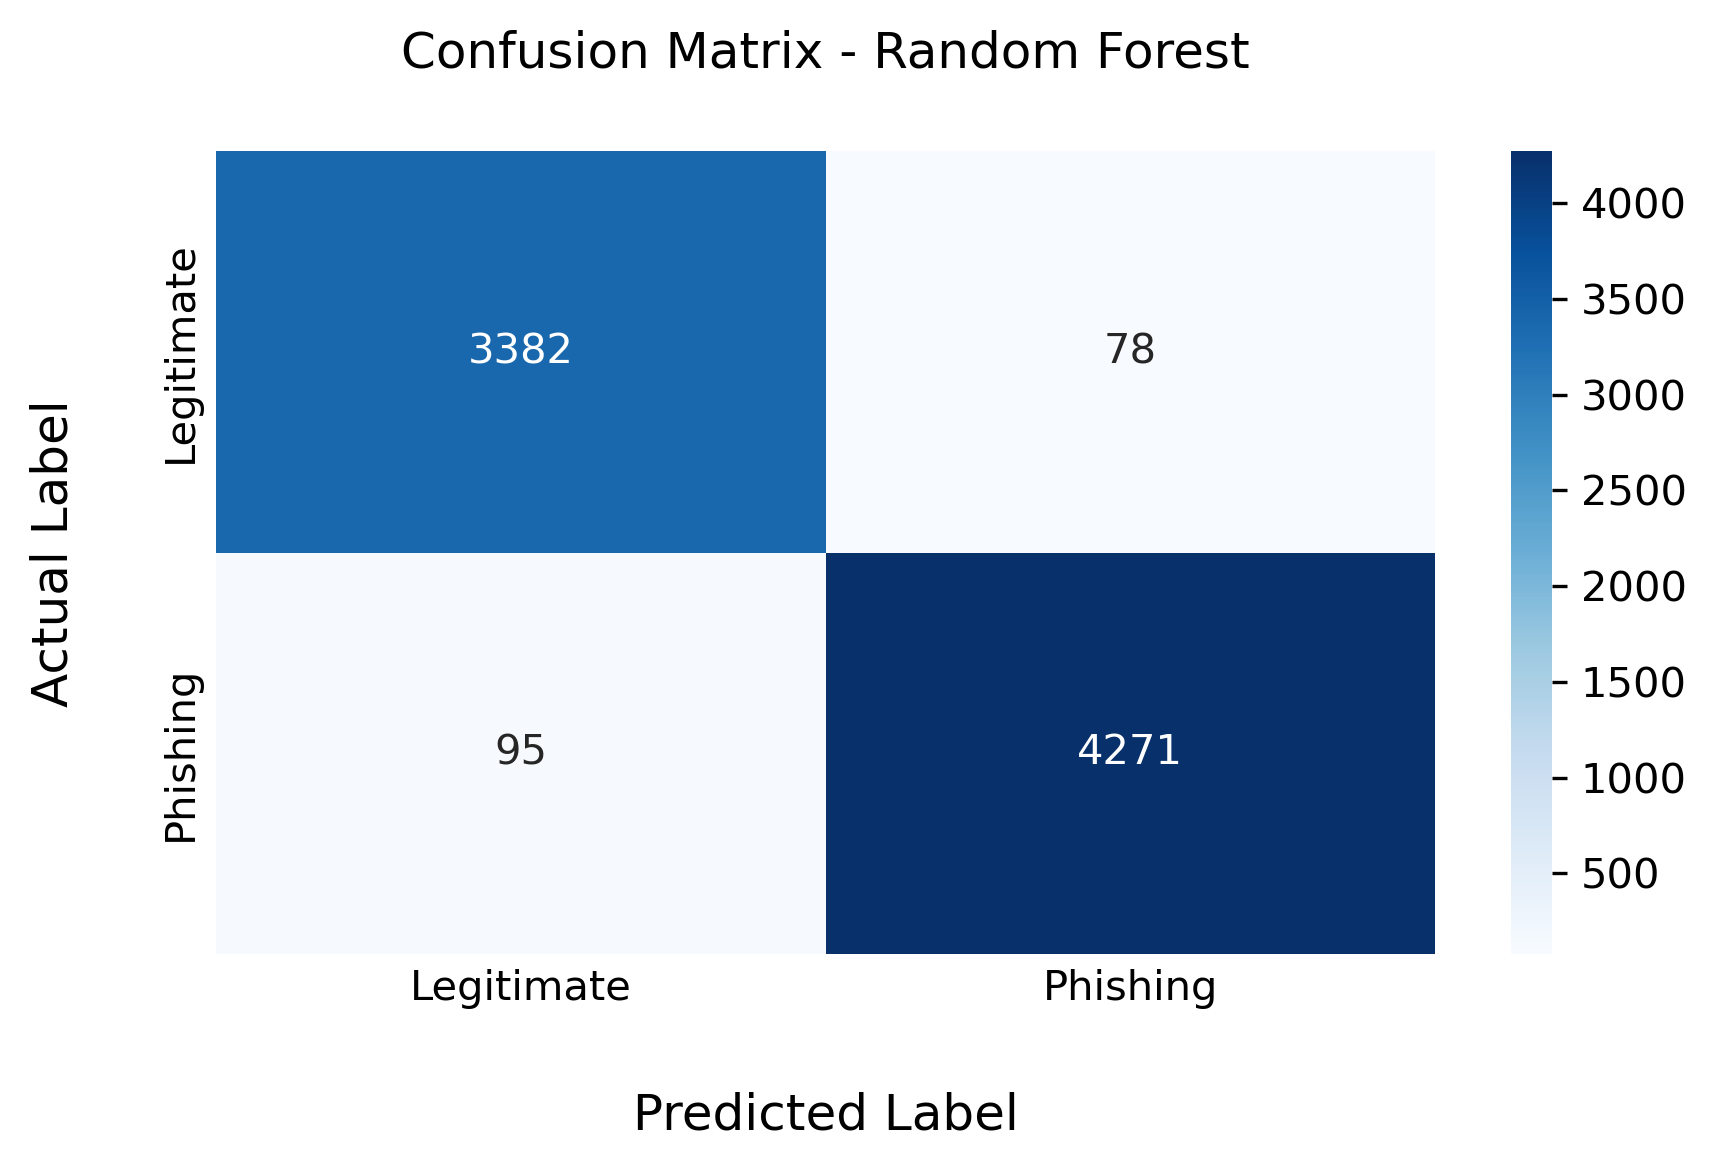

In [ ]:
# Confusion Matrix (Random Forest)

cm_rf = confusion_matrix(y_labels_test, y_pred_rf)

fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

# Plot confusion matrix as a heatmap
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=ax
)

ax.set_title("Confusion Matrix - Random Forest", pad=20)
ax.set_xlabel("Predicted Label", fontsize=12, labelpad=20)
ax.set_ylabel("Actual Label", fontsize=12, labelpad=20)

# Set custom tick labels for clarity
ax.set_xticklabels(["Legitimate", "Phishing"])
ax.set_yticklabels(["Legitimate", "Phishing"])

# Remove tick marks
ax.minorticks_off()
ax.tick_params(axis='y', length=0)
ax.tick_params(axis='x', length=0)

plt.tight_layout()

## fig.savefig("rf_confusion_matrix.png", dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
!pip install xgboost

In [ ]:
# XGBoost Model Training

# Initialize XGBoost classifier with tuned hyperparameters
xgb_model = XGBClassifier(
    n_estimators=300,       # number of boosted trees
    max_depth=6,            # Maximum depth of each tree
    learning_rate=0.1,      # Step size for updating weights
    subsample=0.8,          # Fraction of rows used per tree (helps reduce overfitting)
    colsample_bytree=0.8,   # Fraction of features used per tree
    objective="binary:logistic",  # Binary classification with probability output
    eval_metric="logloss",
    scale_pos_weight=1,     # Can be tuned if classes are highly imbalanced
    random_state=42,
    n_jobs=-1               # Use all CPU cores
)

In [ ]:
# Train the XGBoost model
xgb_model.fit(X_train_final, y_labels_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)

In [ ]:
# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test_final)

In [ ]:
# Print main evaluation metrics
print("\n=== XGBoost Metrics ===")
print("Accuracy:", accuracy_score(y_labels_test, y_pred_xgb))
print("Precision:", precision_score(y_labels_test, y_pred_xgb))
print("Recall:", recall_score(y_labels_test, y_pred_xgb))
print("F1 Score:", f1_score(y_labels_test, y_pred_xgb))

print("\n=== Classification Report (XGBoost) ===")
print(classification_report(y_labels_test, y_pred_xgb))


=== XGBoost Metrics ===
Accuracy: 0.9759775108612317
Precision: 0.9804507819687213
Recall: 0.9764086120018324
F1 Score: 0.9784255221482672

=== Classification Report (XGBoost) ===
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3460
           1       0.98      0.98      0.98      4366

    accuracy                           0.98      7826
   macro avg       0.98      0.98      0.98      7826
weighted avg       0.98      0.98      0.98      7826



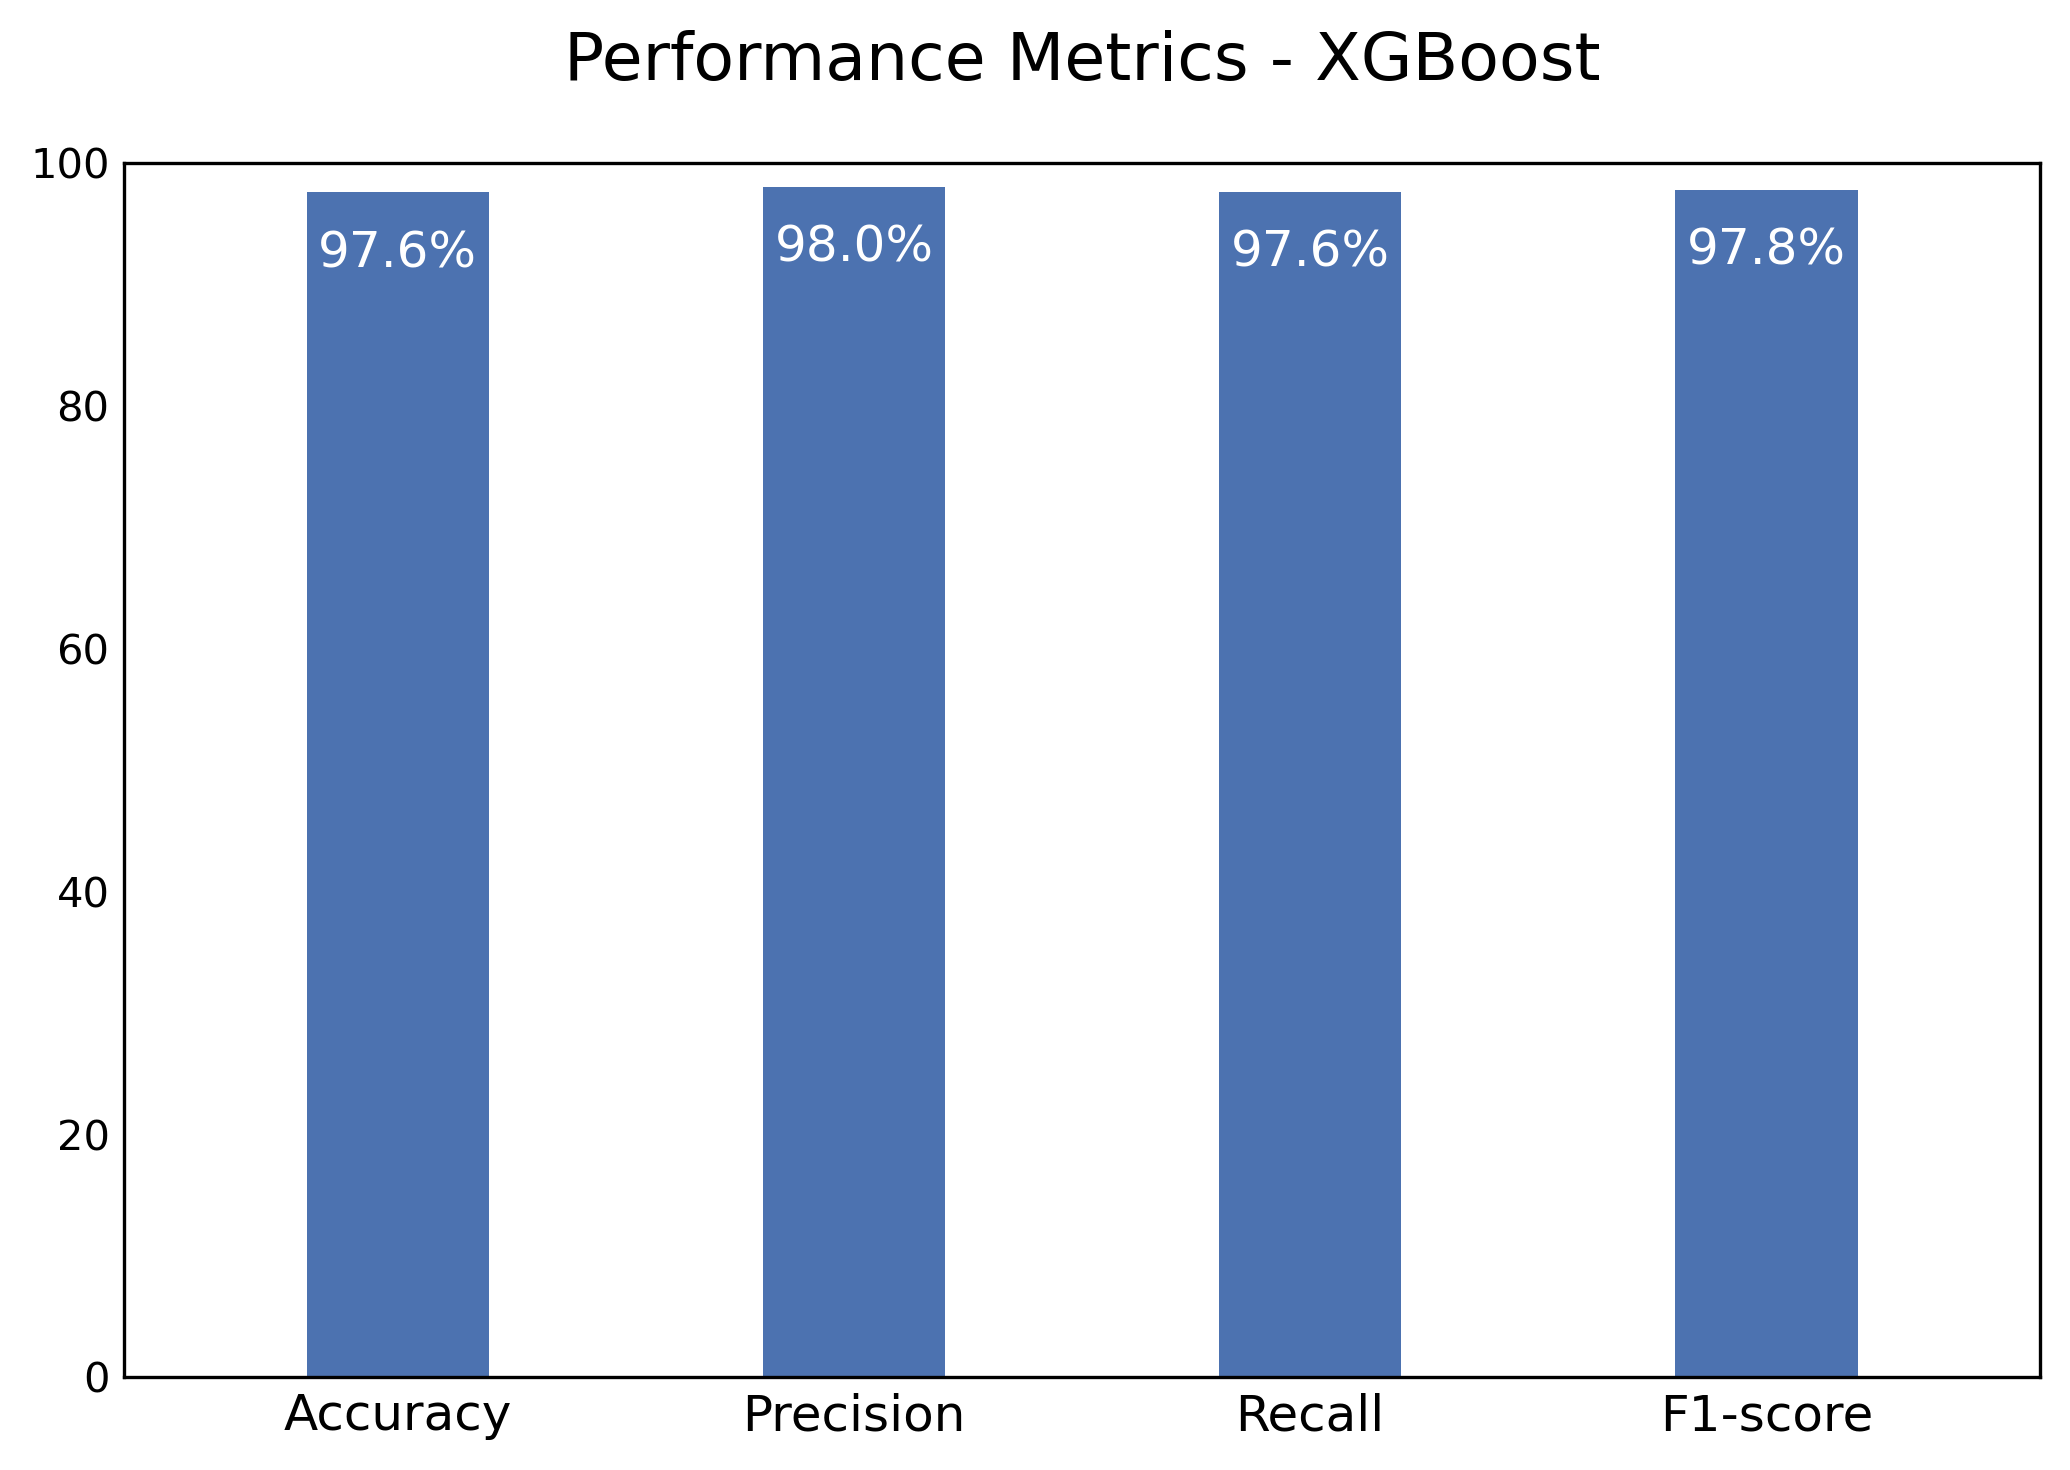

In [202]:
# Bar Chart of Overall Performance Metrics - XGBoost

# Convert metrics to percentages for visualization
xgb_metrics = {
    "Accuracy":  accuracy_score(y_labels_test, y_pred_xgb) * 100,
    "Precision": precision_score(y_labels_test, y_pred_xgb) * 100,
    "Recall":    recall_score(y_labels_test, y_pred_xgb) * 100,
    "F1-score":  f1_score(y_labels_test, y_pred_xgb) * 100,
}

names  = list(xgb_metrics.keys())
values = list(xgb_metrics.values())

fig, ax = plt.subplots(figsize=(7, 5), dpi=300)

# Bar positions and width
x = np.arange(len(names))
bar_width = 0.40

# Draw bars for each metric
bars = ax.bar(x, values, width=bar_width, color="#4C72B0")

# Add percentages inside the bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() - 5,
        f"{val:.1f}%",
        ha="center",
        va="center",
        fontsize=12,
        color="white",
    )

# Configure axes and labels
ax.set_ylim(0, 100)
ax.set_xticks(x)
ax.set_xticklabels(names, fontsize=12)
ax.set_title("Performance Metrics - XGBoost", fontsize=16, pad=20)

# Add margin so bars are not touching the plot borders
plt.xlim(-0.6, len(names) - 0.4)

# Remove tick marks
ax.minorticks_off()
ax.tick_params(axis="y", length=0)
ax.tick_params(axis="x", length=0)

plt.tight_layout()

# fig.savefig("xgb_metrics_percentage.png", dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
# Raw Feature Importance
importance = xgb_model.get_booster().get_score(importance_type='gain')
importance_sorted = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Print top 20 features by gain (using XGBoost's internal feature indices)
for name, score in importance_sorted[:20]:
    print(f"{name:25s} importance = {score:.4f}")

num_urls                  importance = 27.4002
sender_is_free_provider   importance = 27.0613
text_length               importance = 26.6357
max_url_length            importance = 22.6129
has_at_symbol             importance = 21.1201
uppercase_ratio           importance = 15.2938
urgent_word_count         importance = 10.2014
exclamation_count         importance = 10.1053
has_suspicious_tld        importance = 5.6483
has_hex_string            importance = 3.2001
sender_domain_length      importance = 2.7244
has_dash_in_domain        importance = 2.6469
sender_has_numbers        importance = 2.4192
sender_has_dash           importance = 2.2520
has_ip_in_url             importance = 1.1212


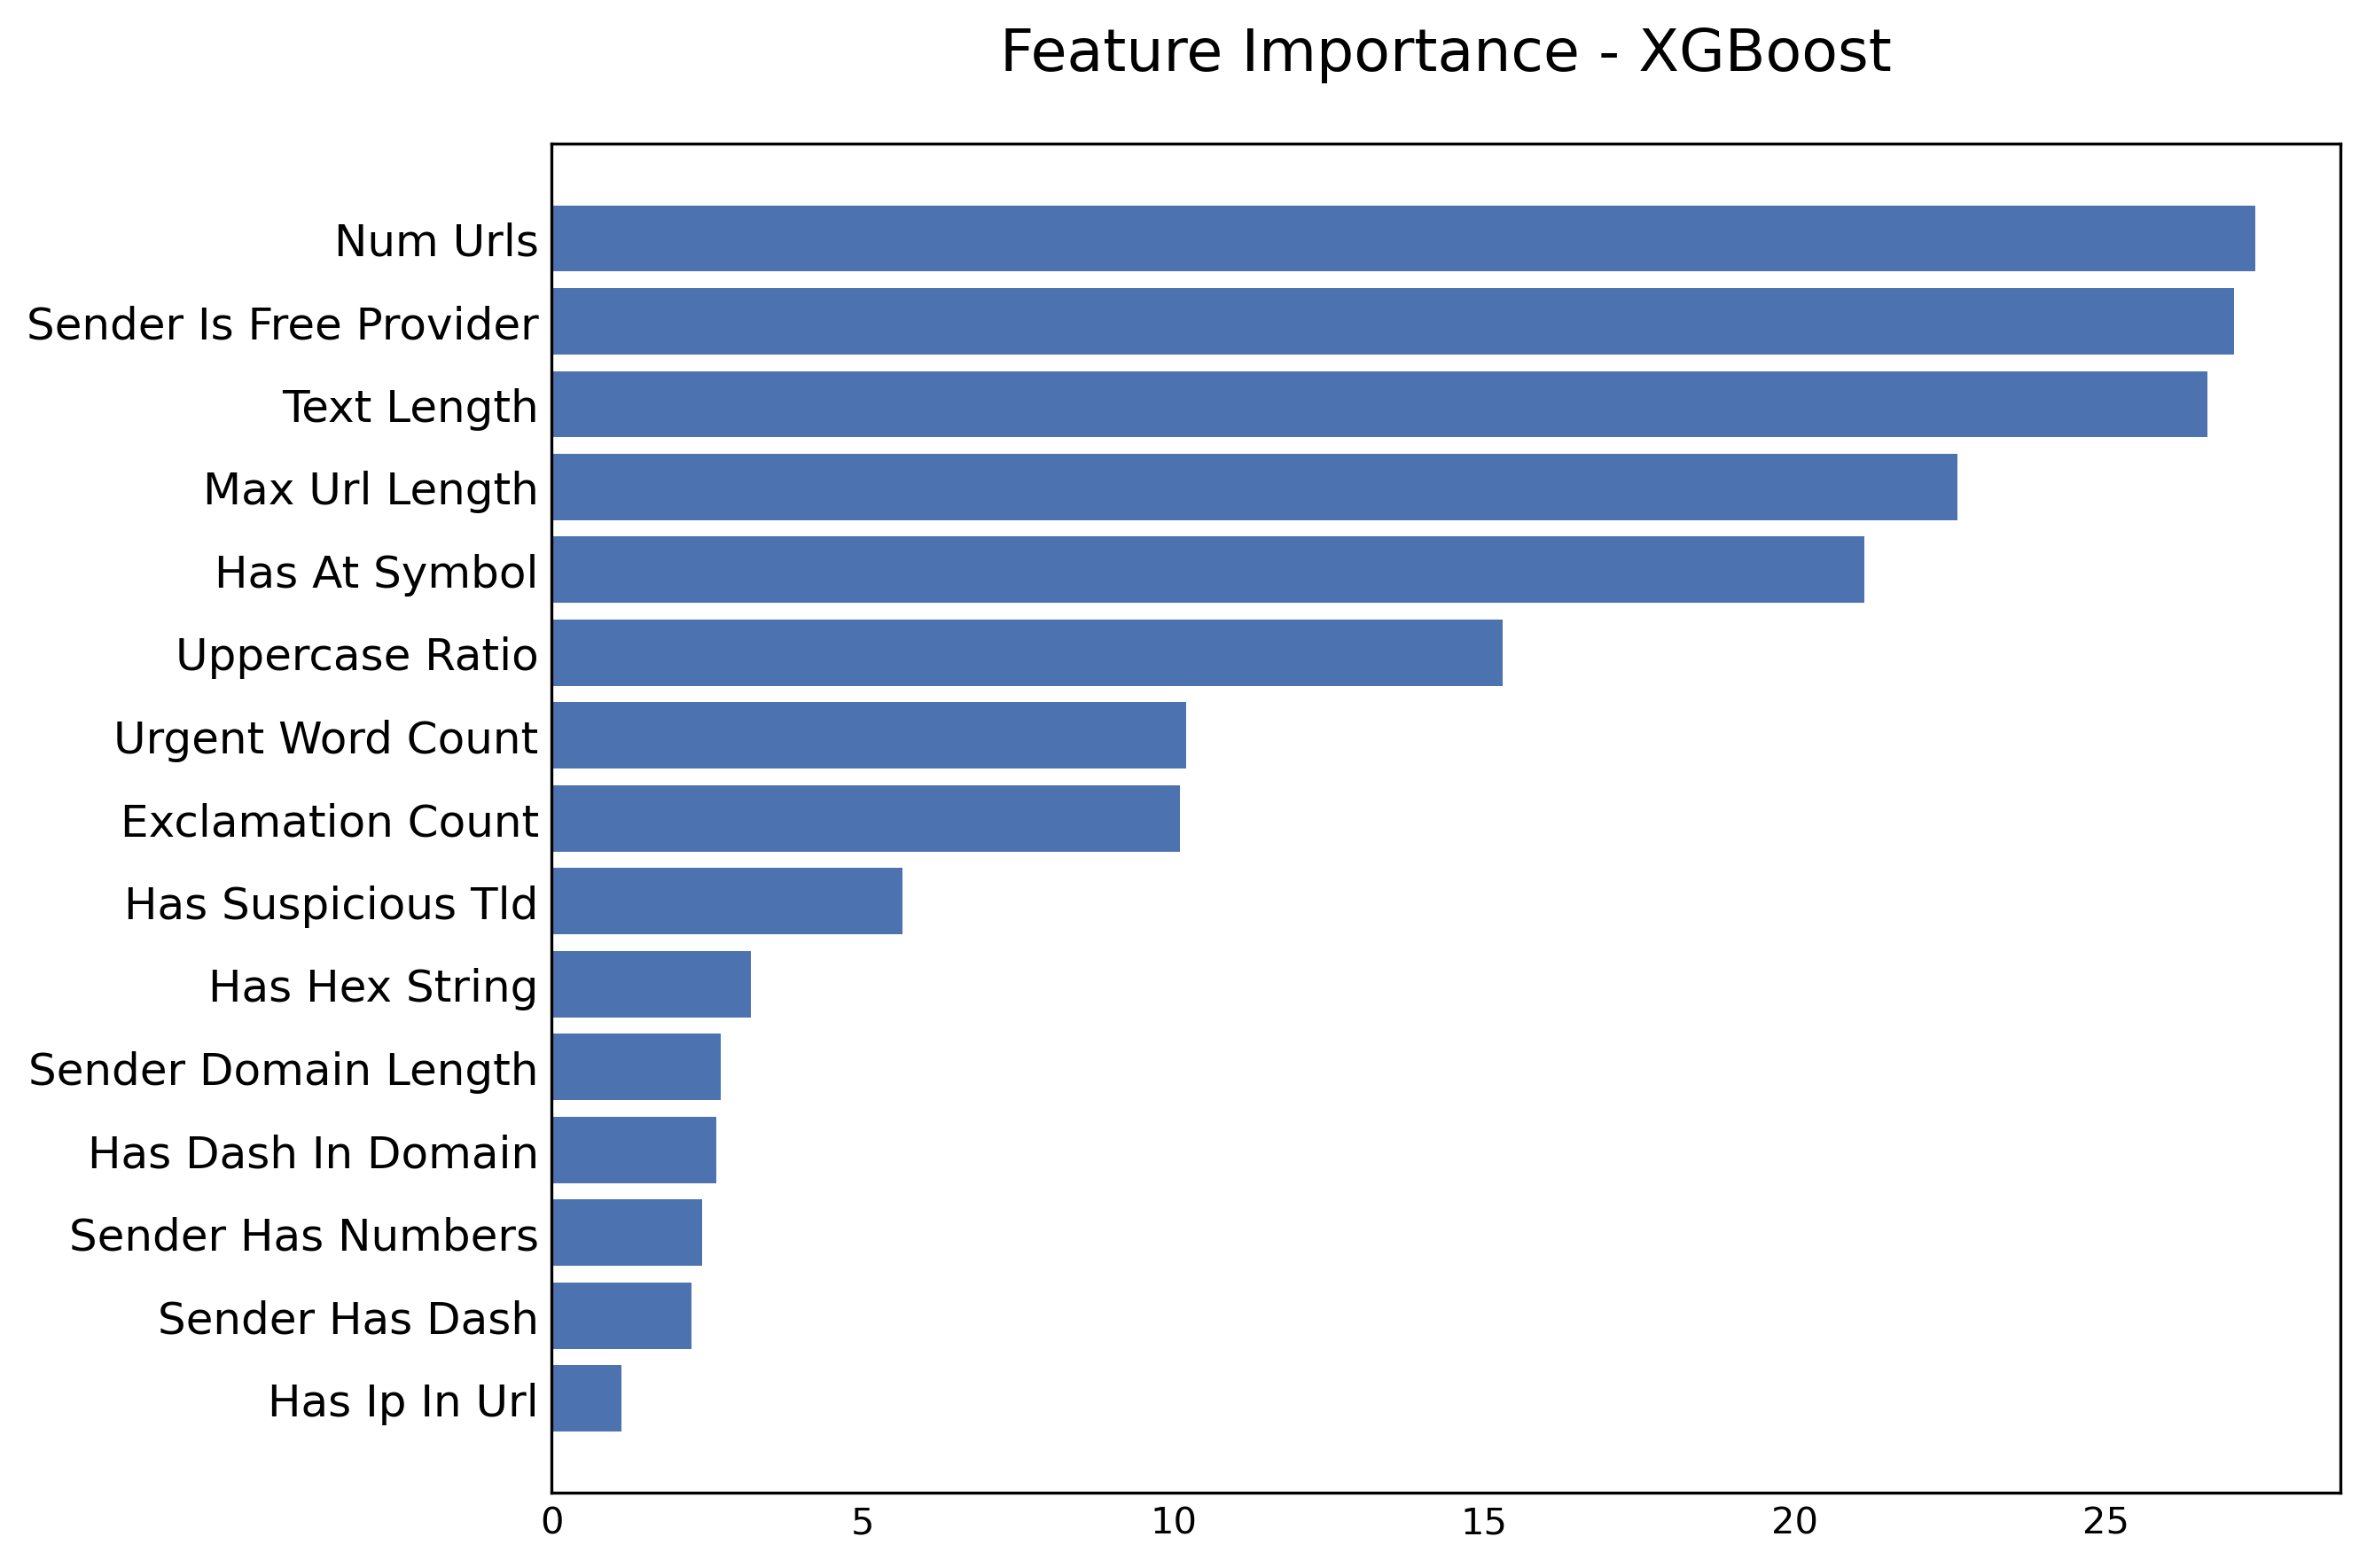

In [ ]:
# Map XGBoost feature keys (f0, f1, ...) to original column names
feature_names = X_train_final.columns
feat_map = {f"f{i}": col for i, col in enumerate(feature_names)}

# Build mapped importance list with real feature names
importance = xgb_model.get_booster().get_score(importance_type="gain")
mapped_importance = [(feat_map.get(k, k), v) for k, v in importance.items()]

# Sort by importance score
importance_sorted = sorted(mapped_importance, key=lambda x: x[1], reverse=True)

top_feats  = [f for f, v in importance_sorted[:15]]
top_scores = [v for f, v in importance_sorted[:15]]

# Clean feature names for readability
clean_features = [f.replace("_", " ").title() for f in top_feats]

fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

# Horizontal bar chart of top 15 features
ax.barh(clean_features, top_scores, color="#4C72B0")

# Show most important features at the top
ax.invert_yaxis()

ax.set_title("Feature Importance - XGBoost", fontsize=16, pad=20)

# Remove tick marks
ax.tick_params(axis="y", length=0, labelsize=12)
ax.tick_params(axis="x", length=0)

plt.tight_layout()

# fig.savefig("xgb_feature_importance_top15.png", dpi=300, bbox_inches="tight")

plt.show()

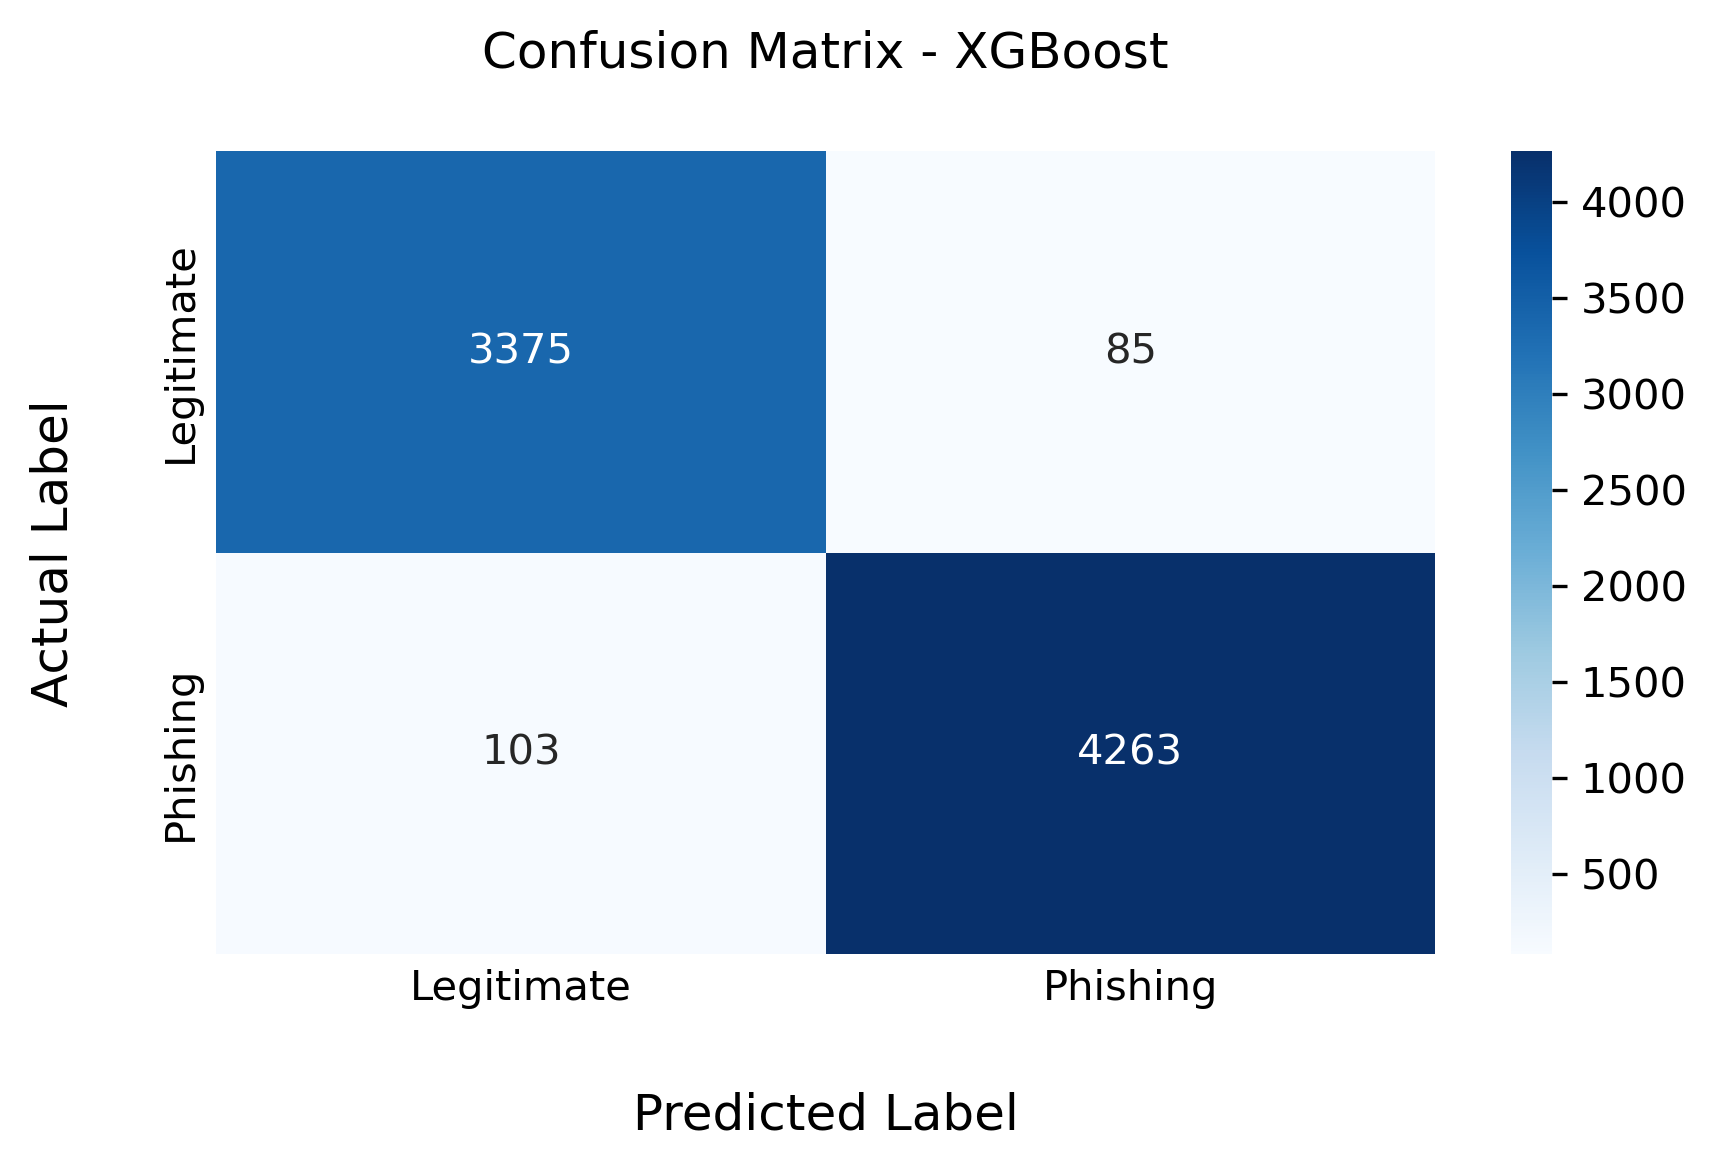

In [206]:
# Confusion Matrix (XGBoost)

cm_xgb = confusion_matrix(y_labels_test, y_pred_xgb)

fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

# Plot confusion matrix as a heatmap
sns.heatmap(
    cm_xgb,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=ax
)

ax.set_title("Confusion Matrix - XGBoost", pad=20)
ax.set_xlabel("Predicted Label", fontsize=12, labelpad=20)
ax.set_ylabel("Actual Label", fontsize=12, labelpad=20)

# Set custom tick labels for clarity
ax.set_xticklabels(["Legitimate", "Phishing"])
ax.set_yticklabels(["Legitimate", "Phishing"])

# Remove tick marks
ax.minorticks_off()
ax.tick_params(axis="y", length=0)
ax.tick_params(axis="x", length=0)

plt.tight_layout()

# fig.savefig("xgb_confusion_matrix.png", dpi=300, bbox_inches="tight")

plt.show()

In [208]:
# Collect metrics (percentages)

logreg_metrics = [
    accuracy_score(y_labels_test, y_pred_logreg) * 100,
    precision_score(y_labels_test, y_pred_logreg) * 100,
    recall_score(y_labels_test, y_pred_logreg) * 100,
    f1_score(y_labels_test, y_pred_logreg) * 100,
]

rf_metrics = [
    accuracy_score(y_labels_test, y_pred_rf) * 100,
    precision_score(y_labels_test, y_pred_rf) * 100,
    recall_score(y_labels_test, y_pred_rf) * 100,
    f1_score(y_labels_test, y_pred_rf) * 100,
]

xgb_metrics = [
    accuracy_score(y_labels_test, y_pred_xgb) * 100,
    precision_score(y_labels_test, y_pred_xgb) * 100,
    recall_score(y_labels_test, y_pred_xgb) * 100,
    f1_score(y_labels_test, y_pred_xgb) * 100,
]

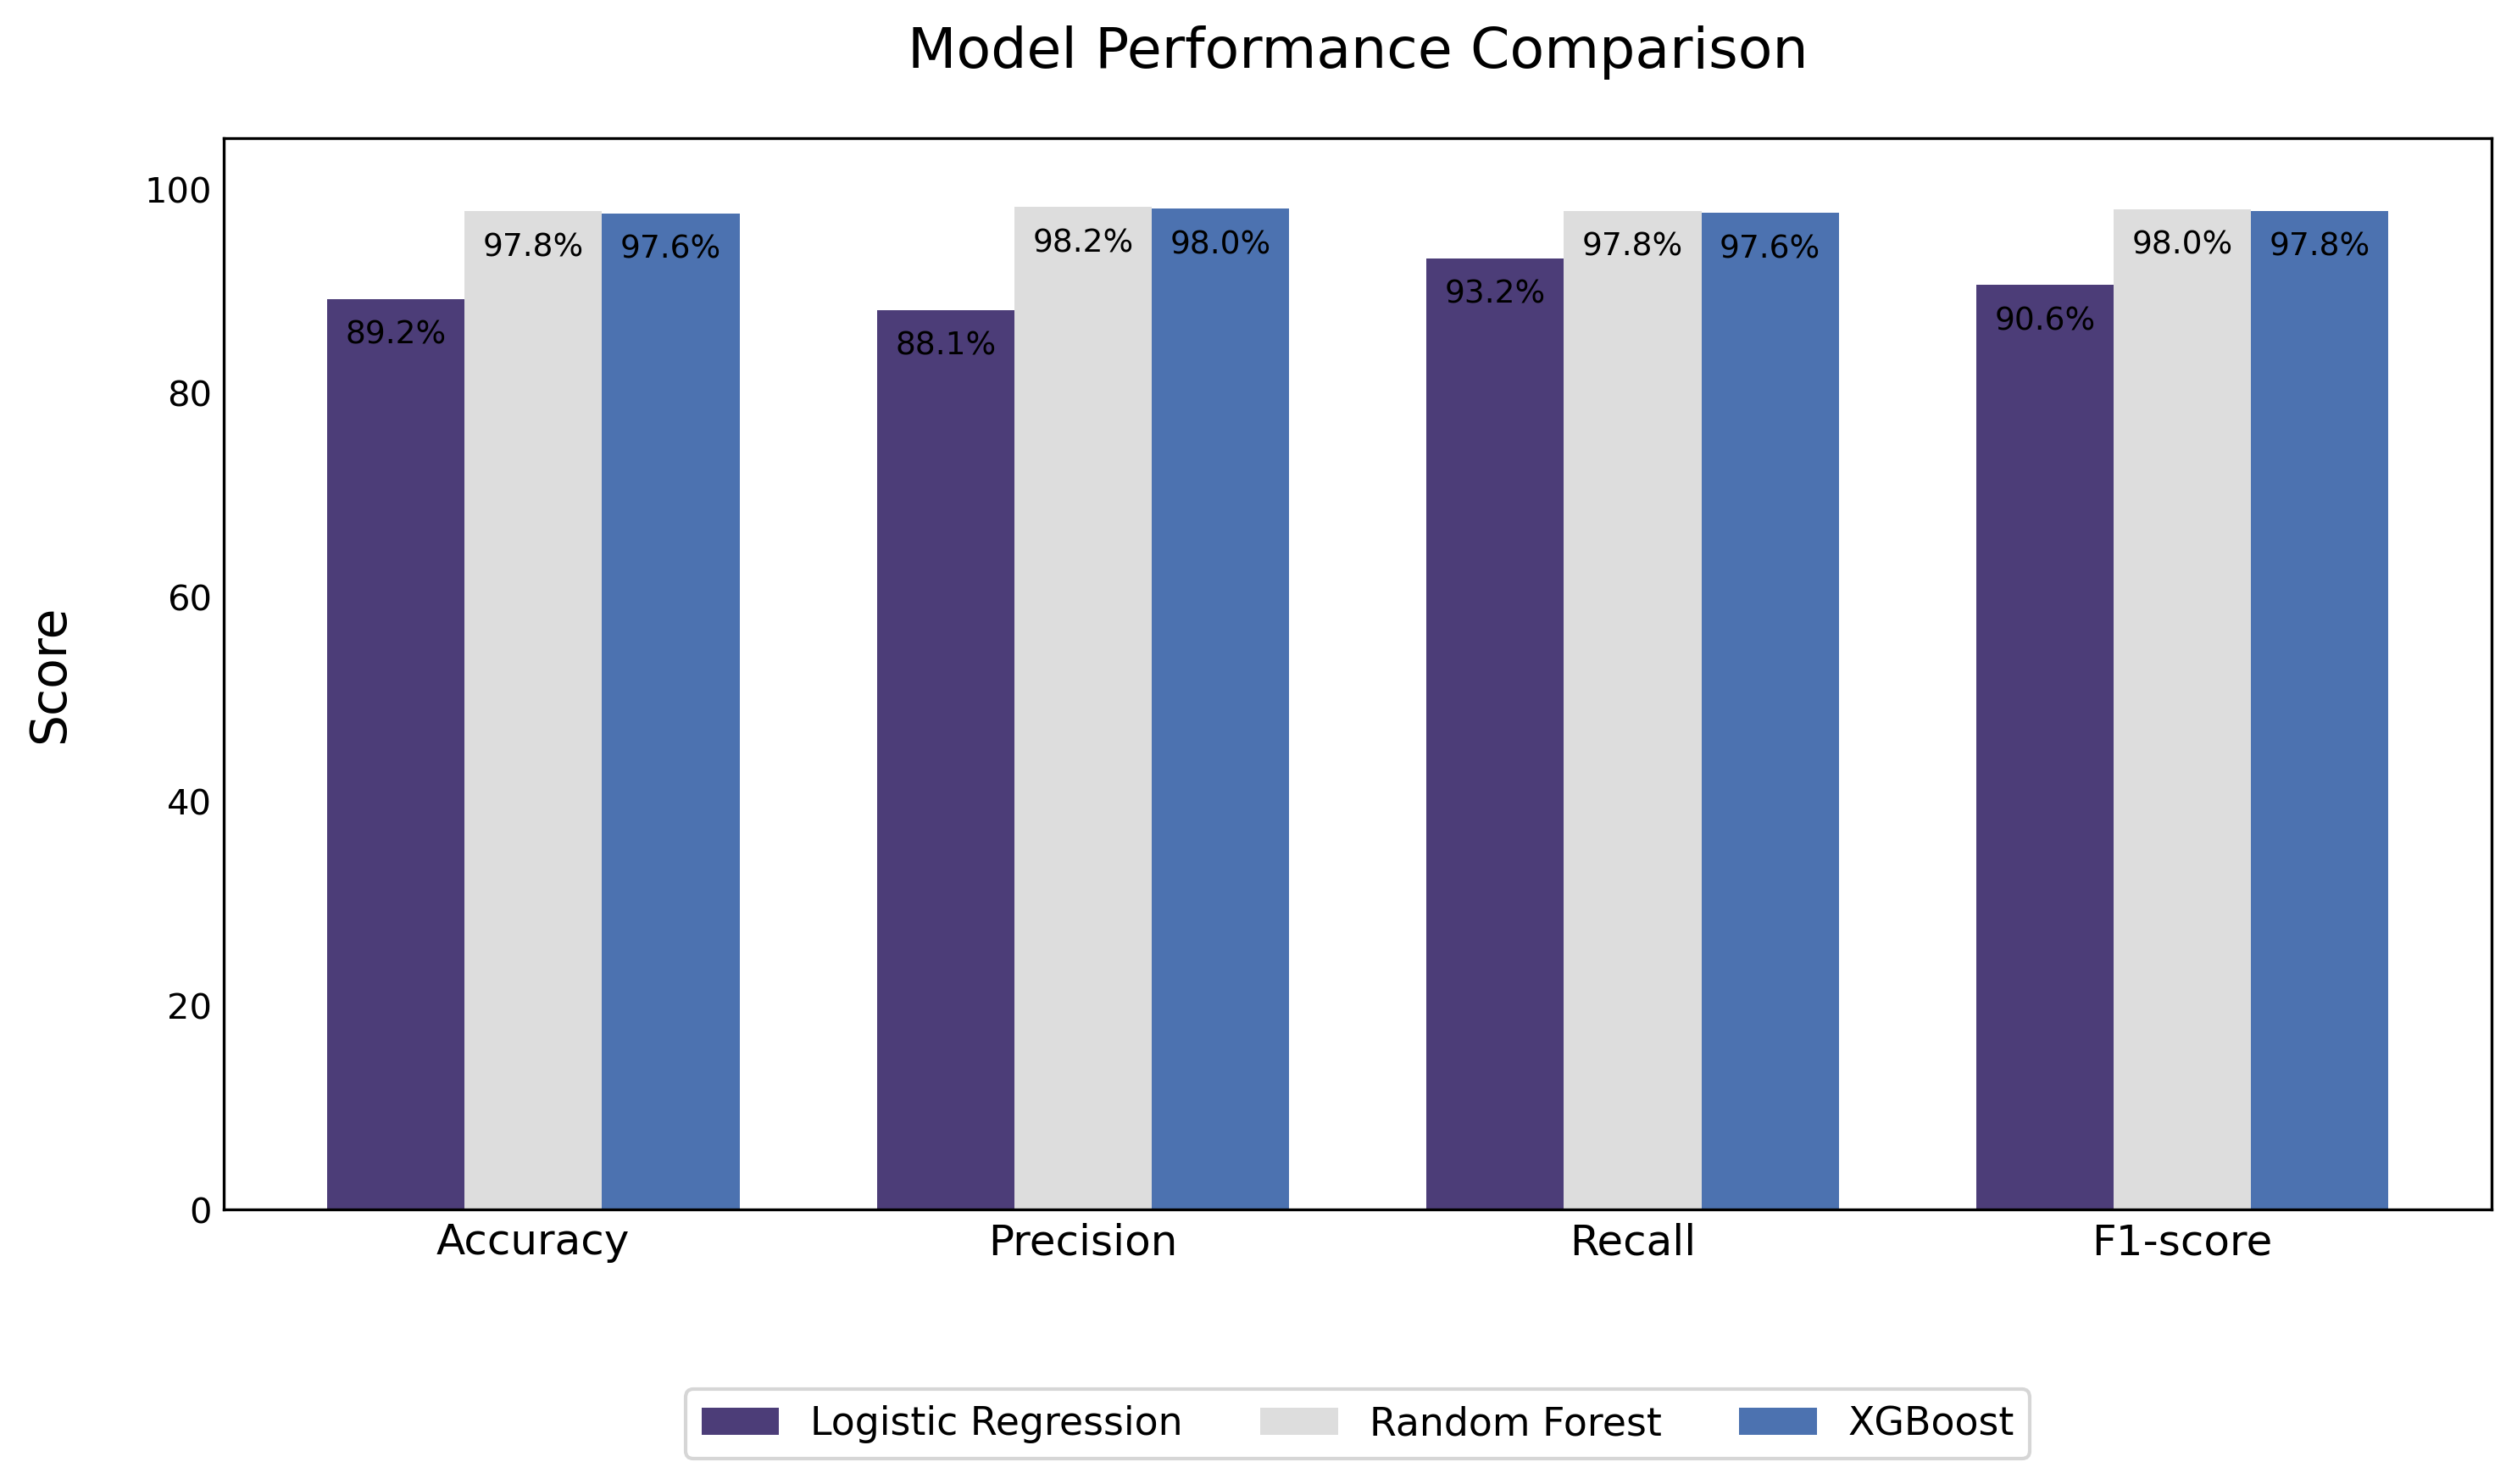

In [216]:
# Models Performance Comparison (LR vs. RF vs. XGBoost)

# Names of evaluation metrics used for comparison
metrics_names = ["Accuracy", "Precision", "Recall", "F1-score"]

# Retrieve previously calculated metric dictionaries
logreg  = logreg_metrics
rf      = rf_metrics
xgb     = xgb_metrics

# Numeric positions for grouped bars
x = np.arange(len(metrics_names))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Plot grouped bars for the three models
bars1 = ax.bar(x - width, logreg, width, label="Logistic Regression", color="#4C3D78")
bars2 = ax.bar(x, rf, width, label="Random Forest", color="#DDDDDD")
bars3 = ax.bar(x + width, xgb, width, label="XGBoost", color="#4C72B0")

# Add percentage labels above bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() - 5,
            f"{height:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9
        )

# Axis formatting
ax.set_ylim(0, 105)
ax.set_xticks(x)
ax.set_xticklabels(metrics_names, fontsize=12)

ax.set_title("Model Performance Comparison", fontsize=16, pad=20)
ax.set_ylabel("Score", fontsize=14, labelpad=20)

# Place legend below the chart
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    fontsize=11,
    frameon=True
)

# Remove tick marks
ax.tick_params(axis='y', length=0)
ax.tick_params(axis='x', length=0)

plt.tight_layout()

# fig.savefig("model_comparison_bar.png", dpi=300, bbox_inches="tight")

plt.show()
